In [119]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [120]:
%load_ext autoreload
%autoreload 2

from icp_pred.arg_utils import is_notebook, get_cfg
cfg = get_cfg()
# choices
classical_models = ["linear", "xgb", "rf"]
nn_models = ["mlp", "rnn", "clip", "gpt"]
# override variables to experiment in notebook
if is_notebook():    
    cfg["auto_lr_find"] = False
    cfg["inner_folds"] = 0
    cfg["target_name"] = "ICP_Vital"   # ICP_Vital" , long_icp_hypertension_2
    cfg["db_name"] = "MIMIC"  # "UKE", "MIMIC", "eICU"
    cfg["minutes"] = 60
    
    cfg["model_type"] = "rnn"
    #cfg["gpt_name"] = "distilgpt2"  # distilgpt2, gpt2, gpt2-medium, gpt2-large(too large)
    #cfg["reduction_factor"] = 16
    
    cfg["use_lens"] = True

    # do experiments on:  fill_type, target_nan_quantile, train_noise_std, 
    #  min_len(increase from 20 to higher), grad_clip_val (at 1 so far), weight_decay (at 0.2 so far)
    
    #cfg["norm_method"] = None # z, or none
    
    cfg["bs"] = 32 # 8 best for rnn, 32 for GPT
    
    cfg["use_in_mapping"] =  True
    cfg["use_out_mapping"] =  True

    # classical model args
    cfg["flat_block_size"] = 0
    # general args
    cfg["max_epochs"] = 10
    cfg["block_size"] = 256
    
    
    cfg["fill_type"] = "ffill" # "none", "pat_mean", "median", "pat_ema" "pat_ema_mask"
    cfg["use_nan_embed"] = False
    cfg["nan_embed_size"] =  128
    cfg["use_nan_embed_transformer"] = 0
    cfg["nan_embed_transformer_n_layers"] = 3
    cfg["nan_embed_transformer_n_heads"] = 8
    
    cfg["weight_decay"] = 0.02
    cfg["grad_clip_val"] = 1.0
    cfg["use_huber"] = 0
    
    cfg["lr"] = 3e-4
    cfg["agg_meds"] = True
    
    # rnn params
    cfg["rnn_type"] = "gru"
    cfg["rnn_layers"] = 1
    
    
    # transformer stats for gpt2
    # 4.338-4.8GB with adapters and batch size 16 and 117 secs
    # 6.620GB with adapters and batch size 32 and only 100 secs
    # 11.074 GB with adapters and batch size 64 and 92 secs
    # also 4.864GB with train_mlp_norm and 127 secss
    # all get to r2 of around 0.48

    # transformer stats for gptneo1.3
    # bs8 2.1GB, 

    # rnn stats for hidden layers size 2048
    # bs 64, 5084MB, 40 secs.
    # bs 128, 8632MB, 38 secs.

    # transformer params
    cfg["mode"] = "adapters"  # "adapters", "train_mlp_norm",  "train_norm", "freeze" (does not train)
    cfg["gpu"] = 1
    
    cfg["num_transformer_blocks"] = 3
    cfg["hidden_size"] = 256
    cfg["n_heads"] = 8
    cfg["dropout"] = 0.2
    
    cfg["seed"] = 0
    cfg["subsample"] = 0.9
    cfg["colsample_bytree"] = 0.9
    
#best_params = {'lr': 0.00023369063418158352, 'weight_decay': 0.18, 'grad_clip_val': 0.1, 'reduction_factor': 4.0, 'randomly_mask_aug': 0.12}
#for k,v in best_params.items():
#    cfg[k] = v
    
    
# overrides and calculated default vals
if cfg["lr"] is None:
    model_type = cfg["model_type"]
    if model_type == "clip":
        cfg["lr"] = 0.001
    elif model_type == "gpt":
        # bs 8 and gpt2 take 9.8GB with max seq len of 512
        # bs 16 with max seq len of 256
        # bs 32 with max seq len 128 only 7.4GB, good performance and fast - 6.9 if mlp_norm
        # bs 64 with len 128 and mlp_norm = 10.9GB. 9.4GB for freeze
        cfg["lr"] = 0.00005
    else:
        cfg["lr"] = 0.0001  # 0.01 works kind of for nan_embed

if cfg["fill_type"] == "none":
    cfg["use_nan_embed"] = 1
        
#cfg["val_check_interval"] = int(cfg["val_check_interval"] * (32 / cfg["batch_size"]))
    
import pytorch_lightning as pl
pl.utilities.seed.seed_everything(seed=cfg["seed"], workers=False)
locals().update(cfg)

Global seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
# set some settings here to load a best-performing hyperparameter set
use_best = True


if use_best:
    # modify these
    cfg["add_diagnosis_features"] = True
    cfg["use_general_features"] = False
    cfg["use_general_features_diag"] = False
    cfg["only_med_and_demo_features"] = False
    cfg["fill_type"] = "ffill"
    
    
    # values for RNN
    cfg["model_type"] = "rnn"
    if cfg["fill_type"] == "ffill":
        best_params_MIMIC = {"bs": 3,
                             "lr": 0.000162,
                             "weight_decay": 0.24,
                             "grad_clip_val": 0.5,}
        best_params_UKE = {"bs": 3,
                             "lr": 0.000444,
                             "weight_decay": 0.3,
                             "grad_clip_val": 0.9,}
    elif cfg["fill_type"] == "none":
        best_params_MIMIC = {"bs": 2,
                             "lr": 0.000271,
                             "weight_decay": 0.12,
                             "grad_clip_val": 0.4,}
        best_params_UKE = {"bs": 2,
                             "lr": 0.000109,
                             "weight_decay": 0.22,
                             "grad_clip_val": 1.4,}
    if cfg["db_name"] == "UKE":
        best = best_params_UKE
    elif  cfg["db_name"] == "MIMIC":
        best = best_params_MIMIC

if use_best:
    best["block_size"] = 256
    best["agg_meds"] = True
    best["use_in_mapping"] = True
    best["use_out_mapping"] = True
    best["model_size"] = "xl"
    best["bs"] = 2 ** best["bs"]
    for key in best:
        cfg[key] = best[key]

In [122]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(cfg["gpu"])

import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

import logging
import pytorch_lightning
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
#pytorch_lightning.utilities.distributed.log.setLevel(logging.ERROR)

In [125]:
# load df
path = f'data/DB_{cfg["db_name"]}_{cfg["minutes"]}_final_df.parquet'
df = pd.read_parquet(path)
print(df.shape)


db_name_2 = None
#db_name_2 = "MIMIC"

if db_name_2 is not None:
    path_2 = f'data/DB_{db_name_2}_{cfg["minutes"]}_final_df.parquet'
    df_2 = pd.read_parquet(path)
    df = pd.concat([df, df_2])
    print(df.shape)

(156645, 99)


In [127]:
def make_df_overview(df):
    diagnose_cols = [c for c in df.columns if "Diagnose" in c]
    print(cfg["db_name"])
    print("Sex female, male:", np.unique(df.groupby("Pat_ID").mean(numeric_only=True).Geschlecht, return_counts=True)[1])
    print("Age:", df.Alter.mean().round(2), df.Alter.std().round(2), df.Alter.min(), df.Alter.max())
    print("Num pats: ", len(df.Pat_ID.unique()))
    print("Num windows: ", len(df.groupby(["Pat_ID", "window_id"]).mean(numeric_only=True)))
    print("Average stay in hours: ", df.groupby(["Pat_ID", "window_id"]).apply(len).mean().round(2))
    print("Num ICP measurements: ", len(df.ICP_Vital.dropna()))
    print("Avg. ICP measurements per patient: ", df.groupby("Pat_ID").apply(lambda x: len(x.ICP_Vital.dropna())).mean().round(2))
    print("Mean ICP:", df.ICP_Vital.mean().round(2))
    print("Std ICP:", df.ICP_Vital.std().round(2))
    print("Number ICP measurements < 0:", (df.ICP_Vital.dropna() < 0).sum())
    print("Number ICP measurements < 22:", (df.ICP_Vital.dropna() < 22).sum())
    print("Number ICP measurements > 22:", (df.ICP_Vital.dropna() > 22).sum())
    print("Number ICP measurements < 10:", (df.ICP_Vital.dropna() < 10).sum())
    print("Number ICP measurements 10-22:", ((df.ICP_Vital.dropna() >= 10) & (df.ICP_Vital.dropna() <= 22)).sum())
    #print("Number ICP measurements > 50:", (df.ICP_Vital.dropna() > 50).sum())
    #print("Number ICP measurements > 60:", (df.ICP_Vital.dropna() > 60).sum())
    #print("Number ICP measurements > 100:", (df.ICP_Vital.dropna() > 100).sum())
    print("Counts per diagnose:\n", df[diagnose_cols].sum())
    
    #print(np.unique(df.Alter, return_counts=True))
make_df_overview(df)

MIMIC
Sex female, male: [439 517]
Age: 55.69 18.03 16.4850970319635 89.030051369863
Num pats:  956
Num windows:  1005
Average stay in hours:  151.7
Num ICP measurements:  132552
Avg. ICP measurements per patient:  138.65
Mean ICP: 10.91
Std ICP: 8.25
Number ICP measurements < 0: 841
Number ICP measurements < 22: 124261
Number ICP measurements > 22: 7221
Number ICP measurements < 10: 65983
Number ICP measurements 10-22: 59348
Counts per diagnose:
 Diagnose_ICH       28462
Diagnose_MISC      11650
Diagnose_SAH       67788
Diagnose_Stroke     9536
Diagnose_TBI       29342
Diagnose_Tumor      9867
dtype: int64


In [130]:
# target ICP statistics
print(len(df))
print(df["ICP_Vital"].describe())
print(df.isna().mean().mean())
print(df["ICP_Vital"].isna().mean())

156645
count    132552.000000
mean         10.912436
std           8.251856
min         -41.000000
25%           6.000000
50%          10.000000
75%          14.000000
max         350.000000
Name: ICP_Vital, dtype: float64
0.483436297282893
0.1538063774777363


In [140]:
# create datamodule with dataloaders
from icp_pred.train_utils import make_train_val_fold

train_split = "dev"

if train_split == "dev":
    cfg["inner_folds"] = 0
    df.loc[df["split"] == "val", "split"] = "train"
    df.loc[df["split"] == "test", "split"] = "val"

dms = make_train_val_fold(df, cfg, cfg["inner_folds"])
dm = dms[0]

In [141]:
# print input shapes 
for dm in dms:
    print(dm.train_ds.flat_inputs.shape)
    print(dm.train_ds.flat_targets.shape)

(121927, 83)
(121927,)


In [142]:
# print quantiles
train_ds = dm.train_ds
if hasattr(train_ds, "lower_target_nan_quantile"):
    print("NaN quantiles:", train_ds.lower_target_nan_quantile, train_ds.upper_target_nan_quantile)
    print("Clip quantiles:", train_ds.lower_target_clip_quantile, train_ds.upper_target_clip_quantile)

NaN quantiles: -28.559200000001756 136.74559999996563
Clip quantiles: -8.0 83.75000000001455


In [143]:
# print features info
print(len(train_ds.feature_names))
train_ds.feature_names

83


Index(['rel_time', 'AF_Vital', 'AF_Vital_std', 'ALT_Labor', 'AST_Labor',
       'Albumin_Labor', 'Alk_Labor', 'Basophile_Labor', 'CK-MB_Labor',
       'CK_Labor', 'Ca_BGA', 'Cl_BGA', 'EVB_Labor', 'Eosinophile_Labor',
       'FiO2_BGA', 'FiO2_Vital', 'Freq gesamt_Vital', 'Freq spontan_Vital',
       'GCS_auge_Vital', 'GCS_motor_Vital', 'GCS_total_Vital',
       'GCS_verbal_Vital', 'Glu_BGA', 'HCO3_BGA', 'HF_Vital', 'HF_Vital_std',
       'Harnstoff-N_Labor', 'Hb_BGA_BGA', 'INR_Labor', 'K_BGA',
       'Kreatinin_Labor', 'Lac_BGA', 'MCHC_Labor', 'MCH_Labor', 'MCV_Labor',
       'Magnesium_Labor', 'Monocyten_Labor', 'Na_BGA', 'PCO2_BGA',
       'PEEP_Vital', 'PO2_BGA', 'Phosphat_Labor', 'Pmean_Vital', 'Ppeak_Vital',
       'Pupille li_Vital', 'Pupille re_Vital', 'RASS_Vital', 'SBE_BGA',
       'SpO2_Vital', 'SpO2_Vital_std', 'TZ_Labor', 'Temp_Vital',
       'Temp_Vital_std', 'Thrombocyten_Labor', 'aPTT_Labor', 'diast_Vital',
       'diast_Vital_max', 'diast_Vital_std', 'mittl_Vital', 'mitt

In [145]:
# create dataloader to test some stats about it
train_iter = iter(dm.train_dataloader())

In [146]:
# test the train dataloader
inputs, targets, lens = next(train_iter)
#print(dm.feature_names)
print(inputs.shape, inputs.min(), inputs.max())
print(targets.shape)
print(targets[~torch.isnan(targets)].mean())
print(lens)
print(lens.float().mean(), lens.max())
# NaNs in inputs
nan_inputs = torch.isnan(inputs).any(dim=1)
print("Nans total and percentage: ", nan_inputs.sum(), nan_inputs.sum().float() / nan_inputs.numel())

torch.Size([8, 256, 83]) tensor(-9.9317) tensor(16.8343)
torch.Size([8, 256, 1])
tensor(-0.0528)
tensor([164,  47, 256, 160,  88, 216,  86,  21])
tensor(129.7500) tensor(256)
Nans total and percentage:  tensor(0) tensor(0.)


Sizes:
- Tiny - 120 K
- Small - 250 K
- Base - 1 M
- Large - 4 M
- XL - 16 M

## LSTM:
First is hidden size, second num layers
- 38   K = 64 , 1
- 140  K = 128, 1
- 240  K = 128, 2
- 940  K = 256, 2
- 3.7  M = 512, 2
- 14.8 M = 1024, 2 - 2.5 GB VRAM with block size 128 and bs 256


## Transformer:
First hidden size, second num blocks
- 40.5 K = 32, 3
- 155 K = 64, 3
- 255 K = 64, 5
- 1   M = 128, 5
- 4   M = 256, 5
- 15.8 M = 512, 5 - 6.8 GB VRAM with block size 128, bs 256
- 15.8 M = 256, 20  - OOM with block size 128, bs 256. 2.6 GB with bs 64

In [151]:
# test model size and memory cell

from icp_pred.train_utils import create_model
import icp_pred.train_utils
import icp_pred.model
import icp_pred.nan_emb

# disable transformers logger warnings
import logging
import transformers
logging.getLogger("transformers").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

device = "cuda"

if cfg["model_type"] in ["mlp", "gpt", "rnn", "transformer"]:
    model = create_model(cfg["model_type"], dms[0], cfg)
    model.to(device)
    
    # print param count
    count = 0
    trainable_param_count = 0
    for n, p in model.named_parameters():
        #print(n, p.shape, p.numel())
        count += p.numel()
        if p.requires_grad:
            trainable_param_count += p.numel()
    print(f"{count / 1000:.1f}, K" if count < 1000000 else f"{count / 1000000:.1f}, M")
    #print(trainable_param_count / 1000, "K")
    
    # set out_mapping weights to 1 to check output scale of pretrained
    #model.out_mapping.weight = torch.nn.Parameter(torch.ones_like(model.out_mapping.weight))
    
    # test model prediction shape on test sample from above
    outs = []
    # get some test preds
    for _ in range(5):
        inputs, targets, lens = next(train_iter)
        with torch.no_grad():
            out = model(inputs.to(device), lens)
        outs.append(out)
        print(out.shape, out.requires_grad)
        print(out.mean(), out.std())
else:
    model = None

14.8, M
torch.Size([8, 256, 1]) False
tensor(0.0361, device='cuda:0') tensor(0.0071, device='cuda:0')
torch.Size([8, 256, 1]) False
tensor(0.0341, device='cuda:0') tensor(0.0049, device='cuda:0')
torch.Size([8, 256, 1]) False
tensor(0.0338, device='cuda:0') tensor(0.0059, device='cuda:0')
torch.Size([8, 256, 1]) False
tensor(0.0333, device='cuda:0') tensor(0.0095, device='cuda:0')
torch.Size([8, 256, 1]) False
tensor(0.0308, device='cuda:0') tensor(0.0084, device='cuda:0')


In [156]:
# train model on datamodule
from icp_pred.train_utils import train_model
import icp_pred.model
import icp_pred.train_utils
import icp_pred.nan_emb

num_seeds = 6

used_dms = dms * num_seeds
models, trainers = train_model(cfg["model_type"], used_dms, cfg, verbose=True, log=False)

Number of trainable parameters:  14781441


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Number of trainable parameters:  14781441


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Number of trainable parameters:  14781441


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Number of trainable parameters:  14781441


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Number of trainable parameters:  14781441


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Number of trainable parameters:  14781441


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [157]:
# clear memory
torch.cuda.empty_cache()
import gc
gc.collect()

30036

In [158]:
import icp_pred.eval_utils
from icp_pred.eval_utils import get_all_dfs, print_all_metrics
import importlib
importlib.reload(icp_pred.eval_utils)
# eval
dl_type = "val"
#dl = external_dls["MIMIC"] # external_dls - MIMIC, eICU, UKE
dl = None

pred_df = get_all_dfs(models, used_dms, cfg["model_type"], dm.regression, 
                      dl_type=dl_type, dl=dl, norm_targets=cfg["norm_targets"])

<AxesSubplot: >

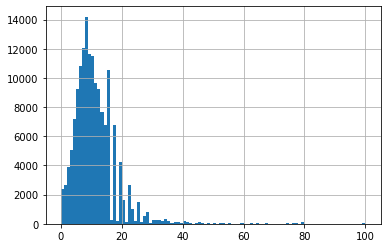

In [159]:
# target hist
pred_df.targets.clip(0, 100).hist(bins=100)

<AxesSubplot: >

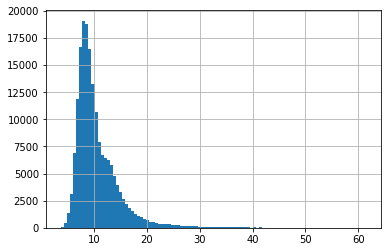

In [160]:
# pred hist
pred_df.preds.hist(bins=100)

In [161]:
# create new df with randomly shuffled targets to debug
shuffled_pred_df = pred_df.copy()
shuffled_pred_df["targets"] = np.random.permutation(shuffled_pred_df["targets"])
mse = (shuffled_pred_df["preds"] - shuffled_pred_df["targets"]) ** 2
mse.mean(), np.sqrt(mse.mean())

(82.15564001761973, 9.063974846479868)

In [162]:
# mse of mean train target
mse = (pred_df["targets"] - pred_df["mean_train_target"]) ** 2
mse.mean(), np.sqrt(mse.mean())

(62.22586213865812, 7.888337095906723)

In [163]:
# our mse
mse = (pred_df["preds"] - pred_df["targets"]) ** 2
mse.mean(), np.sqrt(mse.mean())

(49.761445277414246, 7.054179277379776)

In [164]:
# performance per model
pred_df.groupby("model_id").error.mean()#.hist(bins=10)

model_id
0    0.726616
1    0.699592
2    0.707356
3    0.724309
4    0.711496
5    0.723849
Name: error, dtype: float32

In [165]:
# mae of mean train target
mae = np.abs(pred_df["targets"] - pred_df["mean_train_target"]) 
mae.mean(), np.sqrt(mae.mean())

(5.093964084621643, 2.256981188362376)

In [166]:
# our mae
mae = np.abs(pred_df["preds"] - pred_df["targets"])
mae.mean(), np.sqrt(mae.mean())

(4.596594408604039, 2.143966979364197)

In [169]:
import importlib

import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import icp_pred.eval_utils
importlib.reload(icp_pred.eval_utils)
from icp_pred.eval_utils import get_all_dfs, hypertension_acc, hypertension_auc

def calculate_metrics(df):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    pred_targets = df["targets"].dropna()
    preds = df["preds"][~df["targets"].isna()]
    metrics = {"mse": mean_squared_error(pred_targets, preds),
                "mae": mean_absolute_error(pred_targets, preds),
                "rmse": np.sqrt(mean_squared_error(pred_targets, preds)),
                "min_abs_error": (preds - pred_targets).abs().min(),
                "max_abs_error": (preds - pred_targets).abs().max(),
                "hyp_acc": hypertension_acc(pred_targets, preds),
                "hyp_auc": hypertension_auc(pred_targets, preds),
                "r2": r2_score(pred_targets, preds),
                "baseline_mse": mean_squared_error(pred_targets, df["mean_train_target"][~df["targets"].isna()]),
                "baseline_rmse": np.sqrt(mean_squared_error(pred_targets, df["mean_train_target"][~df["targets"].isna()])),
                "baseline_hyp_acc": hypertension_acc(pred_targets, df["mean_train_target"][~df["targets"].isna()]),
                "baseline_hyp_auc": hypertension_auc(pred_targets, df["mean_train_target"][~df["targets"].isna()]),
                "baseline_r2": r2_score(pred_targets, df["mean_train_target"][~df["targets"].isna()]),
                }
    return metrics

if dm.regression:
    #from eval_utils import hypertension_acc
    pred_targets = pred_df["targets"].dropna()
    preds = pred_df["preds"][~pred_df["targets"].isna()]
    print("Baseline acc for hypertension: ", hypertension_acc(pred_targets, np.zeros((len(pred_targets,)))))
    print("Accuracy for hypertension: ", hypertension_acc(pred_targets, preds))
    print("AUC for hypertension: ", hypertension_auc(pred_targets, preds))

    metrics = calculate_metrics(pred_df)
    
    print(metrics)
    #print_all_metrics(pred_df)
else:
    
    # general metrics
    non_na_pred_df = pred_df.dropna(subset=["targets"])
    binary_preds = non_na_pred_df["preds"] > 0.5
    targets = non_na_pred_df["targets"]
    preds = torch.sigmoid(torch.tensor(non_na_pred_df["preds"].to_numpy())).numpy()
    
    auc = sklearn.metrics.roc_auc_score(targets, preds)
    tpr, fpr, threshs = sklearn.metrics.roc_curve(targets, preds)
    plt.plot(tpr, fpr)
    plt.plot([0, 1], [0, 1], linestyle="--", color="black")
    plt.title(f"ROC Curve - AUC {auc:.3f}")
    plt.show()
    
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(targets, preds)
    plt.plot(precision, recall)
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.show()
    
    matrix = sklearn.metrics.confusion_matrix(targets, binary_preds)
    cm_display = sklearn.metrics.ConfusionMatrixDisplay(matrix).plot()
    print(matrix)
    print("AUC: ", auc)
    print("Mean pred: ", preds.mean())
    
    print("Accuracy: ", sklearn.metrics.accuracy_score(targets, binary_preds))
    
    #train_pred_df = get_all_dfs(models, trainers, cfg["model_type"], dm.regression, dl_type="train", dl=None, calc_new_norm_stats=False)
    #non_na_df = train_pred_df.dropna(subset=["targets"])
    #tpr, fpr, threshs = sklearn.metrics.roc_curve(non_na_df["targets"], non_na_df["preds"])

Baseline acc for hypertension:  0.9363750523231478
Accuracy for hypertension:  0.9372629602851453
AUC for hypertension:  0.8519473549098797
{'mse': 49.76144527741424, 'mae': 4.596594408604038, 'rmse': 7.054179277379775, 'min_abs_error': 6.952657552261599e-05, 'max_abs_error': 315.5843825456309, 'hyp_acc': 0.9372629602851453, 'hyp_auc': 0.8519473549098797, 'r2': 0.20023808420377598, 'baseline_mse': 62.22586213865814, 'baseline_rmse': 7.888337095906724, 'baseline_hyp_acc': 0.9363750523231478, 'baseline_hyp_auc': 0.5, 'baseline_r2': -8.901346506351437e-05}


In [173]:
# get metrics from normal evaluation

from icp_pred.eval_utils import calc_metrics

no_na = pred_df.dropna(subset=["targets"])
pred_targets = [t.unsqueeze(0).numpy() for t in torch.tensor(no_na["targets"].to_numpy())]
preds = torch.tensor(no_na["preds"].to_numpy()).numpy()
metrics, flat_targets, flat_preds = calc_metrics(pred_targets, preds)

metrics

{'mse': 49.76144527741424,
 'mae': 4.596594408604038,
 'rmse': 7.054179277379775,
 'min_abs_error': 6.952657552261599e-05,
 'max_abs_error': 315.5843825456309,
 'hyp_acc': 0.9372629602851453,
 'hyp_auc': 0.8519473549098797,
 'r2': 0.20023808420377598,
 'rmse_clin': 5.909127174525297,
 'mae_clin': 4.627443538711794,
 'hyp_acc_clin': 0.9010010089745633,
 'hyp_auc_clin': 0.7717520643374259}

In [176]:
torch.cuda.empty_cache()

In [177]:
# create saliencies and get metrics with clipped targets (more realistic)

from icp_pred.eval_utils import make_eval_preds

use_ig = False  # integrated gradients are too memory intensive
if use_ig:
    median = used_dms[0].preprocessor.median
    sal_kwargs = {"ig": True, "baseline_data": torch.tensor(median).unsqueeze(0).unsqueeze(0).cuda().float().detach()} 
else:
    sal_kwargs = {"ig": False, "baseline_data": None} 


all_targets, all_preds, all_raw_inputs, all_inputs, all_saliencies = make_eval_preds(models, used_dms, cfg["block_size"],
                                                                                     restrict_to_block_size=cfg["block_size"] <= 16,
                                                                                     clip_targets=1, 
                                                                                     normalize_targets=cfg["norm_targets"],
                                                                                     split = "val",
                                                                                     return_saliency=True,
                                                                                     verbose=True,
                                                                                     sal_kwargs=sal_kwargs,
                                                                                    )
    

100%|█████████████████████████████████████████| 207/207 [00:28<00:00,  7.17it/s]


In [179]:
# general performance
metrics, flat_targets, flat_preds = calc_metrics(all_targets, all_preds)
metrics

{'mse': 43.60565246434449,
 'mae': 4.563481004377691,
 'rmse': 6.603457614336938,
 'min_abs_error': 2.47955322265625e-05,
 'max_abs_error': 77.04947710037231,
 'hyp_acc': 0.9443746669711501,
 'hyp_auc': 0.8573095723216867,
 'r2': 0.22019304413802743,
 'rmse_clin': 5.909145068431031,
 'mae_clin': 4.627464137387019,
 'hyp_acc_clin': 0.9157506239711115,
 'hyp_auc_clin': 0.7744284093690523}

In [181]:
# performance of mean train 
mean_all_preds = []
mean = used_dms[0].preprocessor.mean_train_target
for preds in all_preds:
    mean_all_preds.append(np.ones_like(preds) * mean)

metrics, flat_targets, flat_preds = calc_metrics(all_targets, mean_all_preds)
metrics

{'mse': 55.9271880910776,
 'mae': 5.060298746717797,
 'rmse': 7.478448240850344,
 'min_abs_error': 0.0061435699462890625,
 'max_abs_error': 72.82281017303467,
 'hyp_acc': 0.9451168455507346,
 'hyp_auc': 0.5003467406380028,
 'r2': -0.00015497602940861555,
 'rmse_clin': 5.679868985984704,
 'mae_clin': 3.9790980990156197,
 'hyp_acc_clin': 0.9279910785407042,
 'hyp_auc_clin': 0.5005530973451328}

In [182]:
# export some preds

import json
import pandas as pd

do_export = True
if do_export:
    import datetime
    
    time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    # create save folder based on do_export + export_name
    export_folder = "exports"
    export_name = f'{time_str}_{cfg["db_name"]}_{cfg["minutes"]}_{cfg["add_diagnosis_features"]}\
_{cfg["only_med_and_demo_features"]}_{cfg["use_general_features"]}_{cfg["fill_type"]}'
    export_path = os.path.join(export_folder, export_name)
    os.makedirs(export_path, exist_ok=True)
    
    # save cfg inputs, targets, preds, mean_saliencies
    pd.Series(cfg).to_csv(os.path.join(export_path, "cfg.csv"), index=True)
    # save metrics
    pd.Series(metrics).to_csv(os.path.join(export_path, "metrics.csv"), index=True)

In [183]:
def merge_df_list(all_raw_inputs, num_models):
    num = num_models
    num_pats = len(all_raw_inputs) // num
    split_dfs = [all_raw_inputs[i*num_pats:i*num_pats+num_pats] for i in range(num)]
    for model_idx, split_df in enumerate(split_dfs):
        for i, pat_df in enumerate(split_df):
            pat_df["Pat_ID"] = i
            pat_df["Model_ID"] = model_idx
    split_dfs = [pd.concat(model_df) for model_df in split_dfs]
    input_df = pd.concat(split_dfs)
    return input_df

def merge_tensor_list(all_preds, num_models, name="preds"):
    num = num_models
    num_pats = len(all_preds) // num
    split_dfs = [all_preds[i*num_pats:i*num_pats+num_pats] for i in range(num)]
    for model_idx, split_df in enumerate(split_dfs):
        for i, pat_tensor in enumerate(split_df):
            if len(pat_tensor.shape) == 0:
                pat_tensor = [pat_tensor]
            else:
                pat_tensor = np.array(pat_tensor.squeeze())
            if isinstance(name, str):
                tensor_df = pd.DataFrame({name: pat_tensor})
            else:
                if len(pat_tensor.shape) == 1:
                    pat_tensor = np.array([pat_tensor])
                tensor_df = pd.DataFrame(data=pat_tensor, columns=name)
            tensor_df["Pat_ID"] = i
            tensor_df["Model_ID"] = model_idx
            tensor_df["Step"] = np.arange(len(tensor_df))
            split_dfs[model_idx][i] = tensor_df
    split_dfs = [pd.concat(model_df) for model_df in split_dfs]
    input_df = pd.concat(split_dfs)
    return input_df

In [184]:
def save_model_in_and_outs(num_models, export_path,
                           all_targets, all_preds, all_raw_inputs, all_saliencies):
    # create input+targets+preds df
    input_df = merge_df_list(all_raw_inputs, num_models)
    pred_df = merge_tensor_list(all_preds, num_models, name="preds")
    target_df = merge_tensor_list(all_targets, num_models, name="targets")
    input_df["preds"] = pred_df["preds"].to_numpy()
    input_df["targets"] = target_df["targets"].to_numpy()
    # create saliency df
    saliency_df = merge_tensor_list(all_saliencies, num_models, name=list(dm.feature_names))

    input_df.to_csv(os.path.join(export_path, "inputs_targets_preds.csv"))
    saliency_df.to_csv(os.path.join(export_path, "mean_saliencies.csv"))
    
    return input_df, saliency_df
    
    
# make a nice df for analyses
input_df, saliency_df = save_model_in_and_outs(len(used_dms), export_path,
                       all_targets, all_preds, all_raw_inputs, all_saliencies)

In [188]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from icp_pred.eval_utils import hypertension_auc, hypertension_acc, hypertension_prec_rec_spec, hypertension_specificity

def calc_metric(targets, preds):
    mask = ~targets.isna()
    return pd.DataFrame({
            "r2": r2_score(targets[mask], preds[mask]),
            "std": targets[mask].std(),
            "mean": targets[mask].mean(),
            "count":len(targets[mask]),
            "mse": mean_squared_error(targets[mask], preds[mask]),
            "mae": mean_absolute_error(targets[mask], preds[mask]),
            "rmse": np.sqrt(mean_squared_error(targets[mask], preds[mask])),
            "hyp_auc": hypertension_auc(targets[mask], preds[mask]),
            "hypertension_acc": hypertension_acc(targets[mask], preds[mask]),
            "hypertension_precision": hypertension_prec_rec_spec(targets[mask], preds[mask])[0],
            "hypertension_recall": hypertension_prec_rec_spec(targets[mask], preds[mask])[1],
            "hypertension_specificity": hypertension_prec_rec_spec(targets[mask], preds[mask])[2],
    }, 
        
        index=[0]).round(5)

In [189]:
# calc CI if interesting

import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

means = input_df.groupby("Geschlecht").apply(lambda m: m.groupby("Model_ID").apply(lambda x: calc_metric(x.targets, x.preds)).mean())
stds = input_df.groupby("Geschlecht").apply(lambda m: m.groupby("Model_ID").apply(lambda x: calc_metric(x.targets, x.preds)).std())
ci = input_df.groupby("Geschlecht").apply(lambda m: m.groupby("Model_ID").apply(lambda x: calc_metric(x.targets, x.preds)).apply(mean_confidence_interval)).round(3)

In [191]:
input_df.groupby("Geschlecht").apply(lambda x: calc_metric(x.targets, x.preds))

,,r2,std,mean,count,mse,mae,rmse,hyp_auc,hypertension_acc,hypertension_precision,hypertension_recall,hypertension_specificity
Geschlecht,,,,,,,,,,,,,
0.0,0,0.21620,6.97699,10.03900,85620,38.15358,4.14310,6.17686,0.86818,0.96300,0.52459,0.19827,0.99296
1.0,0,0.20347,7.92982,11.77929,72024,50.08692,5.06322,7.07721,0.83380,0.92223,0.46954,0.25147,0.97686


In [192]:
diag_cols = [c for c in input_df.columns if "Diagnose" in c]
cols = ["mse", "rmse", "mae", "hypertension_acc", "hyp_auc", "r2"]

input_df["Diagnose"] = "Other"
for diag in diag_cols:
    if len(diag.split("_")) == 1:
        continue
    name = diag.split("_")[1]
    mask = input_df[diag] == 1
    input_df.loc[mask, "Diagnose"] = name
    

In [194]:
# general 
means = calc_metric(input_df.targets, input_df.preds).round(4)
means

,r2,std,mean,count,mse,mae,rmse,hyp_auc,hypertension_acc,hypertension_precision,hypertension_recall,hypertension_specificity
0,0.2202,7.4779,10.8341,157644,43.6056,4.5635,6.6035,0.8573,0.9444,0.4858,0.2316,0.9858


In [195]:
# general stds
stds = input_df.groupby("Model_ID").apply(lambda x: calc_metric(x.targets, x.preds)).std().round(4).reset_index(drop=False)
stds.round(4)

,index,0
0,r2,0.0135
1,std,0.0000
2,mean,0.0000
3,count,0.0000
4,mse,0.7548
5,mae,0.0351
6,rmse,0.0572
7,hyp_auc,0.0043
8,hypertension_acc,0.0013
9,hypertension_precision,0.0241


In [199]:
# general conf int
ci = input_df.groupby("Model_ID").apply(lambda x: calc_metric(x.targets, x.preds)).apply(mean_confidence_interval).round(3).reset_index()
ci

,index,r2,std,mean,count,mse,mae,rmse,hyp_auc,hypertension_acc,hypertension_precision,hypertension_recall,hypertension_specificity
0,0,0.206,7.478,10.834,26274.0,42.814,4.527,6.543,0.853,0.943,0.462,0.215,0.984
1,1,0.234,7.478,10.834,26274.0,44.398,4.600,6.663,0.862,0.946,0.512,0.248,0.988


In [233]:
# define age group
input_df["Age Group"] = "Adult"
input_df.loc[input_df["Alter"] > 60, "Age Group"] = "Elderly (>60)"

input_df.groupby("Age Group").apply(lambda x: calc_metric(x.targets, x.preds)).round(2)

,,r2,std,mean,count,mse,mae,rmse,hyp_auc,hypertension_acc,hypertension_precision,hypertension_recall,hypertension_specificity
Age Group,,,,,,,,,,,,,
Adult,0,0.24,8.82,12.65,73608,58.94,5.31,7.68,0.83,0.90,0.50,0.28,0.97
Elderly (>60),0,0.03,5.59,9.24,84036,30.17,3.91,5.49,0.80,0.98,0.27,0.03,1.00


In [234]:
# to create tables from the paper, use this

# mean (std) for all groups

subgroup = "Diagnose"  # Diagnose, Age Group, Geschlecht

cols = ["r2", "mse", "mae", "rmse"]
hyp_cols = ["hyp_auc", "hypertension_acc", "hypertension_precision", "hypertension_recall", "hypertension_specificity"]
metric_cols = cols + hyp_cols


mean = input_df.groupby(subgroup).apply(lambda m: m.groupby("Model_ID").apply(lambda x: calc_metric(x.targets, x.preds)).mean()).round(5).reset_index()
std = input_df.groupby(subgroup).apply(lambda m: m.groupby("Model_ID").apply(lambda x: calc_metric(x.targets, x.preds)).std()).round(5).reset_index()


mean[hyp_cols] *= 100
std[hyp_cols] *= 100

mean = mean.round(2)
std = std.round(2)

# TODO:

mean[cols]

both = mean.astype(str) + " (" + std.astype(str) + ")"
both[subgroup] = mean[subgroup]
both.index = both[subgroup]

both[cols]
#both[hyp_cols]

,r2,mse,mae,rmse
Diagnose,,,,
ICH,-0.1 (0.03),31.9 (0.78),4.03 (0.08),5.65 (0.07)
MISC,0.28 (0.05),85.73 (5.67),6.59 (0.22),9.25 (0.31)
SAH,0.16 (0.01),34.97 (0.33),4.04 (0.02),5.91 (0.03)
Stroke,0.09 (0.08),26.34 (2.26),3.83 (0.2),5.13 (0.22)
TBI,0.13 (0.03),74.76 (2.28),6.11 (0.12),8.65 (0.13)
Tumor,-0.27 (0.04),22.99 (0.8),3.82 (0.05),4.79 (0.08)


In [204]:
both[hyp_cols]

,hyp_auc,hypertension_acc,hypertension_precision,hypertension_recall,hypertension_specificity
Diagnose,,,,,
ICH,71.66 (2.26),98.5 (0.09),56.51 (15.08),9.78 (5.83),99.87 (0.09)
MISC,79.74 (2.31),89.19 (0.82),48.67 (6.24),29.91 (3.6),96.24 (0.51)
SAH,80.65 (1.6),97.1 (0.05),64.13 (6.67),8.17 (0.51),99.86 (0.04)
Stroke,86.34 (4.19),97.75 (0.0),nan (nan),0.0 (0.0),100.0 (0.0)
TBI,74.73 (0.89),82.64 (0.63),47.52 (2.69),29.79 (2.49),93.3 (1.15)
Tumor,45.38 (7.14),99.7 (0.02),0.0 (nan),0.0 (0.0),99.99 (0.02)


In [235]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def make_roc_with_std(input_df, name="", path=""):
    input_df_nona = input_df.dropna(subset="targets")

    preds = input_df_nona.preds
    #mask = ~targets.isna()
    #preds = preds[mask].to_numpy()
    targets = input_df_nona.targets.astype(int).to_numpy() > 22
    #fpr, tpr, thresholds = roc_curve(targets, preds, drop_intermediate=True)  #[1, 0, 1, 0, 1, 0, 0], [0.9, 0.8, 0.7, 0.7, 0.6, 0.5, 0.4])

    thresholds = np.linspace(min(preds), max(preds), 300)

    all_fprs = []
    all_tprs = []
    for model_id in input_df_nona.Model_ID.unique():
        sub_df = input_df_nona[input_df_nona.Model_ID == model_id]

        preds_sub = sub_df.preds    
        targets_t = sub_df.targets > 22


        fpr_m = []
        tpr_m = []
        for t in thresholds:
            preds_t = preds_sub > t
            CP = (preds_t == 1)
            CN = (preds_t == 0)

            TP = (preds_t == targets_t)[CP].sum()
            FP = (preds_t != targets_t)[CP].sum()
            TN = (preds_t == targets_t)[CN].sum()
            FN = (preds_t != targets_t)[CN].sum()

            #print(t)
            #print(TP, FP, TN, FN)
            #break
            tpr_m.append(TP / (TP + FN + 1))
            fpr_m.append(FP / (TN + FP + 1))
        all_fprs.append(fpr_m)
        all_tprs.append(tpr_m)

    fpr_mean = np.mean(all_fprs, axis=0)
    fpr_std = np.std(all_fprs, axis=0)
    tpr_mean = np.mean(all_tprs, axis=0)
    tpr_std = np.std(all_tprs, axis=0)

    #print(tpr_mean)
    #print(tpr_std)
    roc_auc = auc(fpr_mean, tpr_mean)

    lw = 2
    plt.figure()
    plt.plot(fpr_mean, tpr_mean, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.fill_between(fpr_mean, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.4, color="darkorange")
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title(f'{name} Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    
    if len(path) > 0:
        # save
        plt.savefig(os.path.join(path, str(name) + ".pdf"))


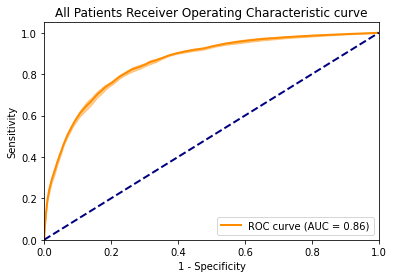

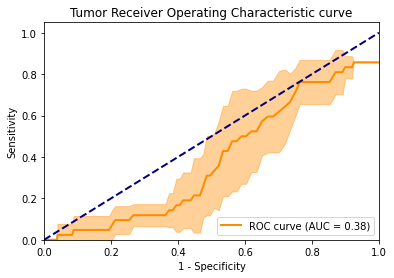

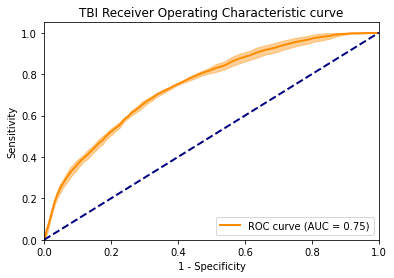

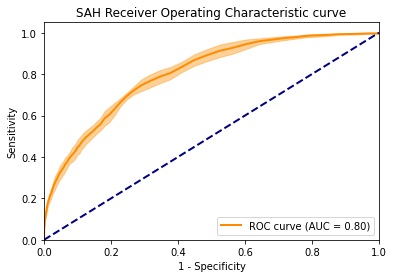

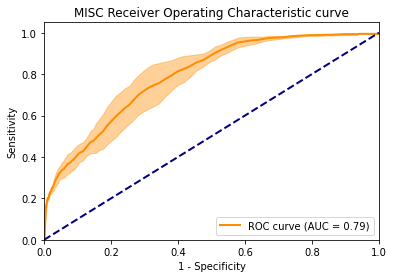

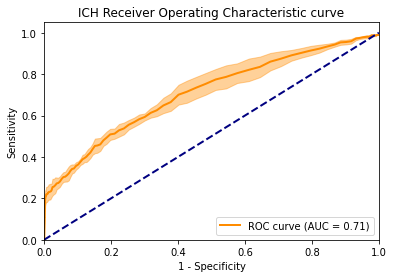

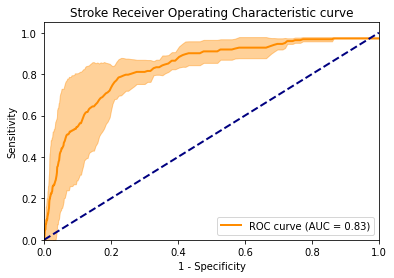

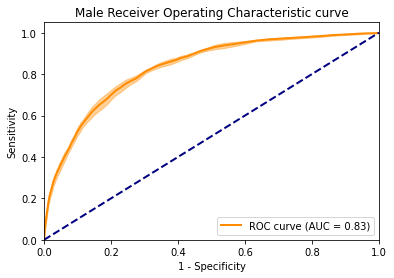

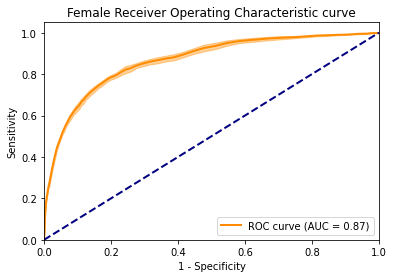

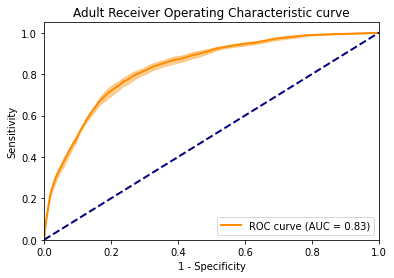

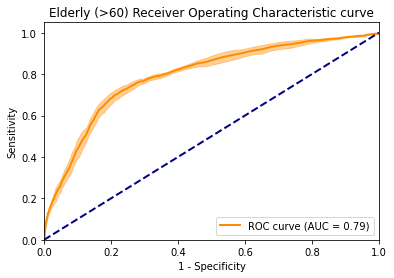

In [236]:
save_path = os.path.join(export_path, "aucs")
os.makedirs(save_path, exist_ok=True)

make_roc_with_std(input_df, "All Patients", save_path)
for diag in input_df.Diagnose.unique():
    diag_df = input_df[input_df.Diagnose == diag]    
    make_roc_with_std(diag_df, diag, save_path)
    
for sex in input_df.Geschlecht.unique():
    sex_df = input_df[input_df.Geschlecht == sex]
    name = "Male" if sex == 1 else "Female"
    make_roc_with_std(sex_df, name, save_path)
    
for age in input_df["Age Group"].unique():
    age_df = input_df[input_df["Age Group"] == age]
    make_roc_with_std(age_df, age, save_path)

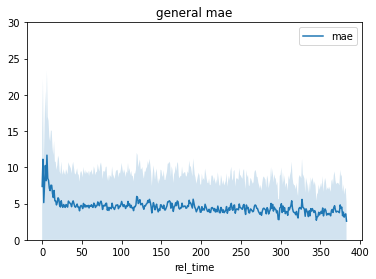

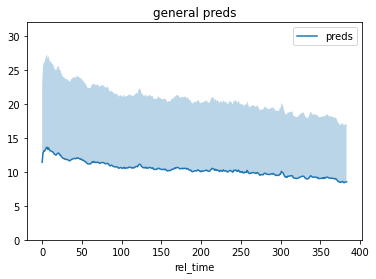

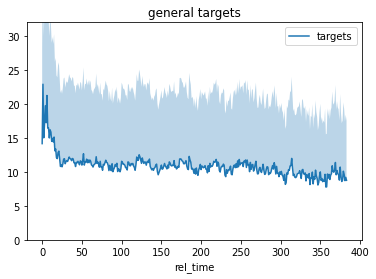

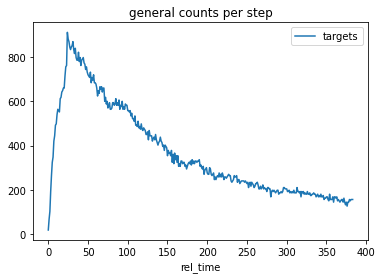

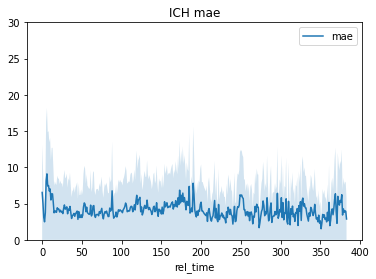

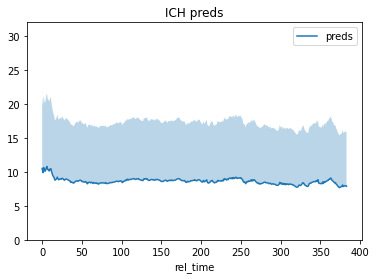

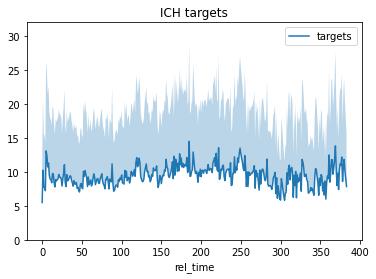

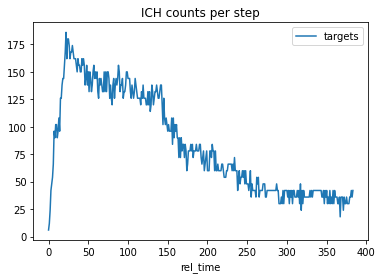

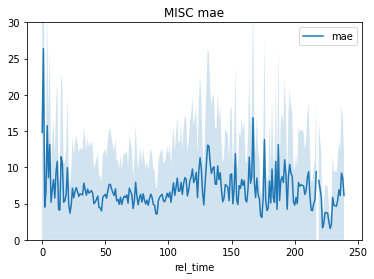

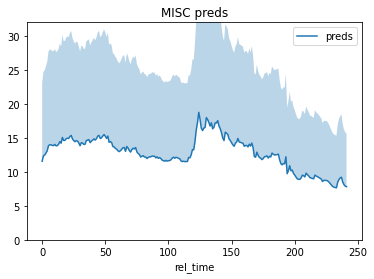

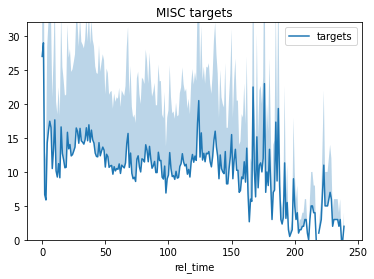

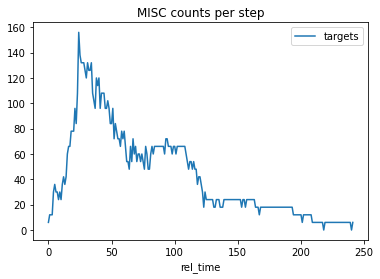

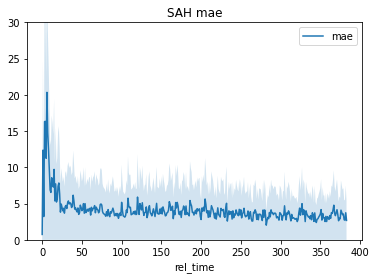

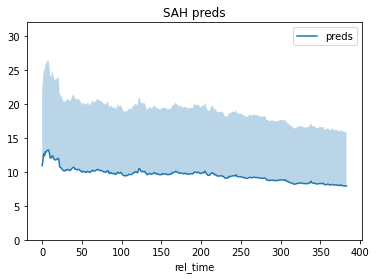

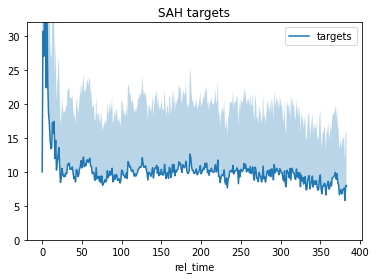

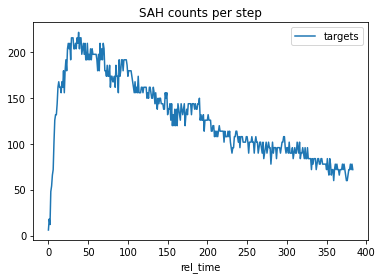

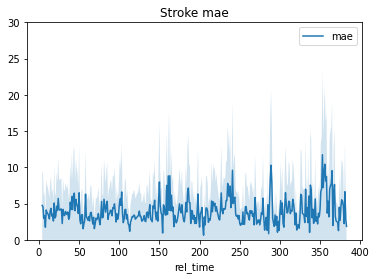

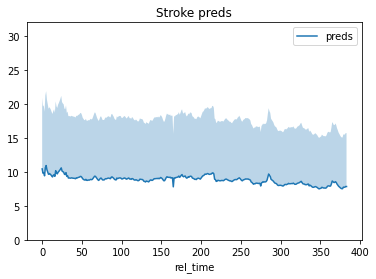

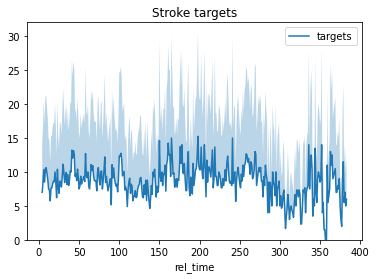

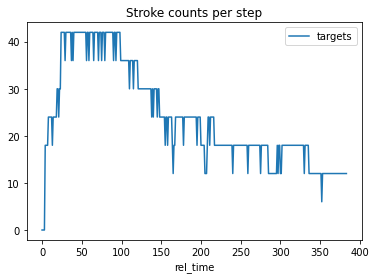

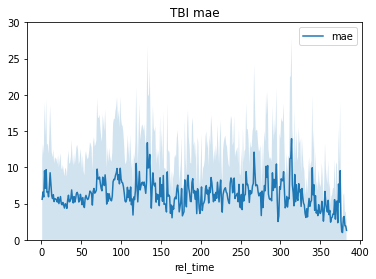

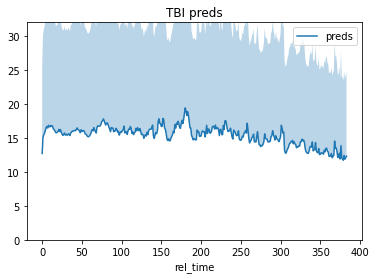

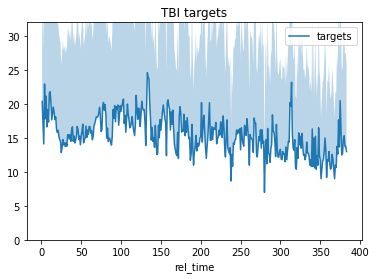

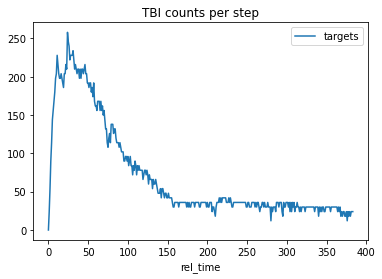

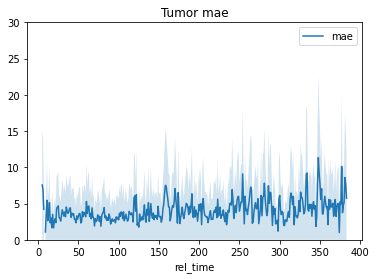

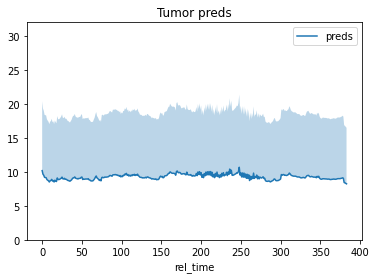

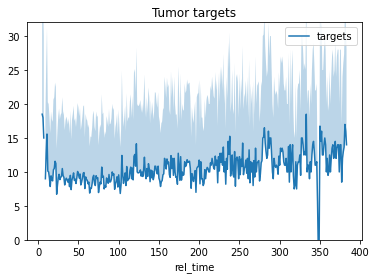

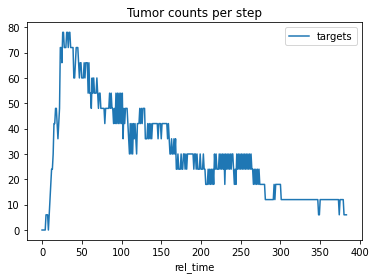

In [237]:
# mse subgroup plots

def make_time_error_plot(input_df, path, name):
    N = 96 * 4
    
    path = os.path.join(path, name)
    
    input_df["mae"] = np.abs(input_df["preds"] - input_df["targets"])
    input_df["mae"] = input_df["mae"].astype(float)
    input_df["preds"] = input_df["preds"].astype(float)
    input_df["targets"] = input_df["targets"].astype(float)
    first_n_hours = input_df.groupby("Pat_ID").apply(lambda x: x[x.rel_time < N * 60].sort_values("rel_time")).reset_index(drop=True)
    #first_n_hours = first_n_hours[first_n_hours.Diagnose == "ICH"]
    
    first_n_hours.rel_time /= 60
    count = first_n_hours.groupby(["rel_time"]).count().reset_index()

    mean_pat = first_n_hours.groupby(["rel_time"]).mean().reset_index()
    std_pat = first_n_hours.groupby(["rel_time"]).mean().reset_index()


    length = min(N, len(mean_pat))
    
    ax = mean_pat.plot(x="rel_time", y="mae")
    ax.fill_between(np.arange(0, length), (mean_pat - std_pat)["mae"], (mean_pat + std_pat)["mae"], alpha=0.2)
    plt.title(name + " mae")
    plt.ylim(0, 30)
    plt.savefig(path + "_mae.pdf")
    
    ax = mean_pat.plot(x="rel_time", y="preds")
    ax.fill_between(np.arange(0, length), (mean_pat - 0)["preds"], (mean_pat + std_pat)["preds"], alpha=0.3)
    plt.ylim(0, 32)
    plt.title(name + " preds")
    plt.savefig(path + "_preds.pdf")
    
    ax = mean_pat.plot(x="rel_time", y="targets")
    ax.fill_between(np.arange(0, length), (mean_pat - 0)["targets"], (mean_pat + std_pat)["targets"], alpha=0.3)
    plt.ylim(0, 32)
    plt.title(name + " targets")
    plt.savefig(path + "_targets.pdf")

    count.plot(x="rel_time", y="targets")
    plt.title(name + " counts per step")
    plt.savefig(path + "_counts.pdf")
    
    
time_path = os.path.join(export_path, "time_plots")
os.makedirs(time_path, exist_ok=True)


make_time_error_plot(input_df, time_path, "general")
for diag in np.unique(input_df.Diagnose):
    sub_df = input_df[input_df.Diagnose == diag]
    make_time_error_plot(sub_df, time_path, diag)

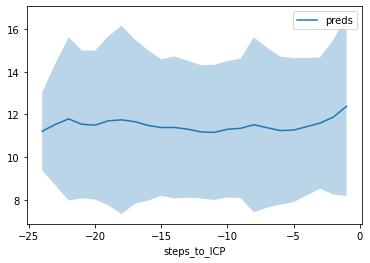

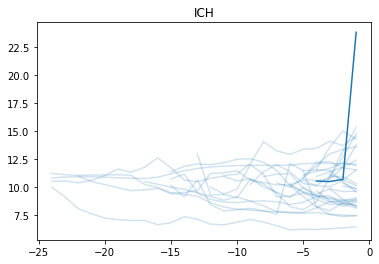

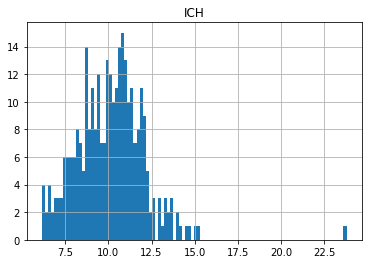

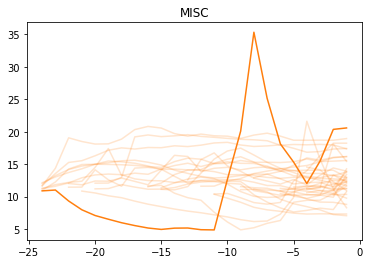

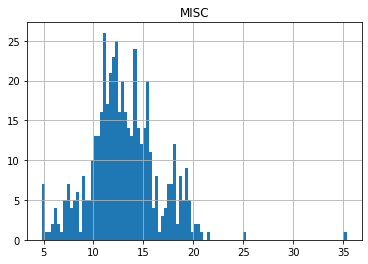

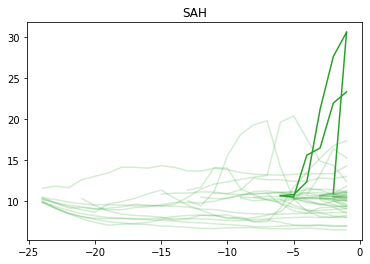

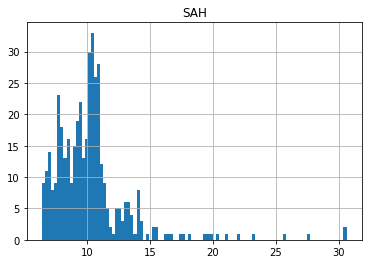

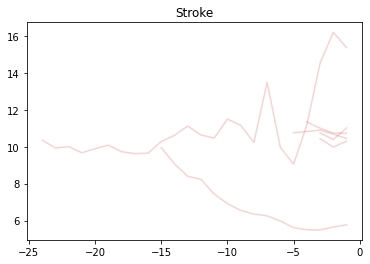

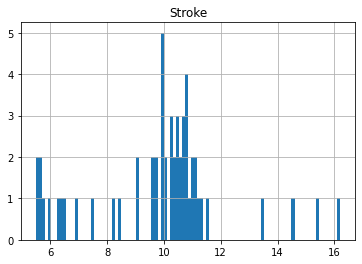

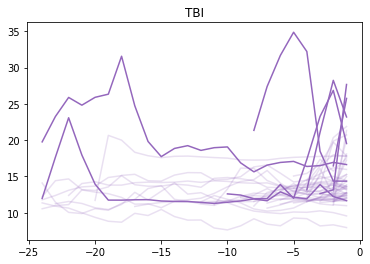

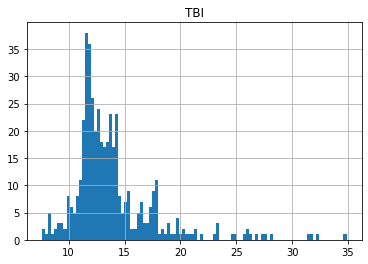

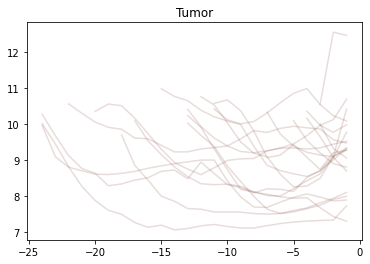

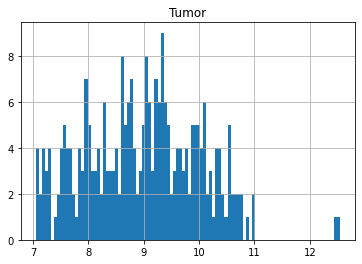

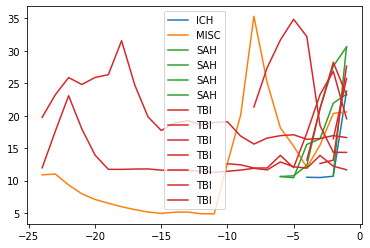

In [215]:
# make plot of all predictions before first ICP measurement

before_measurement_path = os.path.join(export_path, "pred_before_first_icp_measurement")
os.makedirs(before_measurement_path, exist_ok=True)

steps_before_first_icp = input_df.groupby("Pat_ID").apply(lambda pat: pat.iloc[0:np.where(~pat.targets.isna())[0][0]]).reset_index(drop=True)
steps_before_first_icp["steps_to_ICP"] = steps_before_first_icp.groupby("Pat_ID").apply(lambda pat: 
                                                                                        pd.Series(range(len(pat), 0, -1)) * -1
                                                                                         ).reset_index(drop=True)

mean_pat = steps_before_first_icp.groupby(["steps_to_ICP"]).mean().reset_index()
std_pat = steps_before_first_icp.groupby(["steps_to_ICP"]).std().reset_index()


ax = mean_pat.plot(x="steps_to_ICP", y="preds")
ax.fill_between(np.arange(-24, 0), (mean_pat - std_pat)["preds"], (mean_pat + std_pat)["preds"], alpha=0.3)


os.makedirs(before_measurement_path, exist_ok=True)


threshold = 22

for idx, diag in enumerate(np.unique(steps_before_first_icp.Diagnose)):
    fig = plt.figure()
    ax = plt.gca()
    
    diag_path = os.path.join(before_measurement_path, diag)
    
    
    diag_df = steps_before_first_icp[steps_before_first_icp.Diagnose == diag]
    #color = None
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][idx]
    
        
    for pat_id in np.unique(diag_df.Pat_ID):
        pat_preds = diag_df[diag_df.Pat_ID == pat_id].copy()
        if (pat_preds.preds > threshold).sum() > 0:
            alpha = 1.0
        else:
            alpha = 0.2
            
        extra_kwargs = {}
        if color is not None:
            extra_kwargs["color"] = color
        ax.plot(pat_preds["steps_to_ICP"], pat_preds["preds"], alpha=alpha, **extra_kwargs)
        #color = p[0].get_color()
        plt.title(diag)
        plt.savefig(diag_path + "_single_trajectories.pdf")

    # histogram
    plt.figure()
    diag_df.preds.hist(bins=100)
    plt.title(diag)
    plt.savefig(diag_path + "_hist.pdf")



# mixed plot of all diags
fig = plt.figure()
ax = plt.gca()

high_ICP_df = steps_before_first_icp.groupby("Pat_ID").filter(lambda pat: (pat.preds > threshold).sum() > 0)

for diag in np.unique(high_ICP_df.Diagnose):
    diag_df =  high_ICP_df[high_ICP_df.Diagnose == diag]
    color = None
    
    for pat_id in np.unique(diag_df.Pat_ID):
        pat_preds = diag_df[diag_df.Pat_ID == pat_id].copy() 
        
        #pat_preds.preds = pat_preds.preds.clip(5, 40)
        
        extra_kwargs = {}
        if color is not None:
            extra_kwargs["color"] = color
            
        p = ax.plot(pat_preds["steps_to_ICP"], pat_preds["preds"], label=diag,  **extra_kwargs)
        color = p[0].get_color() # 'b'
        
plt.legend()

<AxesSubplot: >

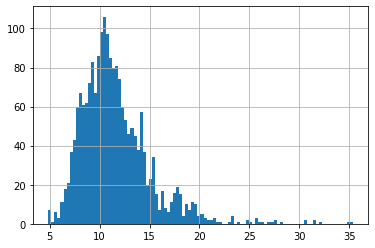

In [221]:
steps_before_first_icp.preds.hist(bins=100)

In [224]:
# save individual saliencies! takes some time

save_all_step_saliencies = False

# do it only for best model, as it takes long
def mse_score(x):
    return (x.targets - x.preds) ** 2
model_perf = input_df.groupby("Model_ID").apply(lambda x: mse_score(x[~x.targets.isna()]).mean())
best_model_idx = np.argmin(model_perf)
print("Best Model idx: ", best_model_idx)

from icp_pred.saliency import get_attr_single
if save_all_step_saliencies:
    # single attributions
    num = len(models)
    num_pats = len(all_preds) // len(models)
    split_dfs = [all_inputs[i*num_pats:i*num_pats+num_pats] for i in range(num)]


    base_ind_sal_path = os.path.join(export_path, "ind_sals")

    overall_ind_sal = []

    #for model_idx, split_df in enumerate(split_dfs):
    for idx in [best_model_idx]:
        model_idx = best_model_idx
        split_df = split_dfs[model_idx]

        model = models[model_idx]
        model.train()

        model_sal = []
        model_ind_sal_path = os.path.join(base_ind_sal_path, f"model_{model_idx}")
        for pat_idx, pat in enumerate(tqdm(split_df)):
            # cut up manually in 128 before and set max_len in call to 0
            pat_path = os.path.join(model_ind_sal_path, f"pat_{pat_idx}")
            os.makedirs(pat_path, exist_ok=True)
            pat_sal = []
            for i in range(len(pat)):
                start = max(i - 128, 0)
                part = pat[start:i + 1]
                sal = get_attr_single(model, pat_id=None, max_len=0, 
                                      pat_data=part, last_step=True)
                sal_df = pd.DataFrame(sal, columns=dm.feature_names)

                sal_df.to_csv(os.path.join(pat_path, f"step_{i}.csv"))
                pat_sal.append(sal_df)
            model_sal.append(pat_sal)
        overall_ind_sal.append(model_sal)

        model.eval()


Best Model idx:  1


In [225]:
# eval on other database - does not transfer as DBs are too different
db_name = cfg["db_name"]
def do_eval_on_ext(models, dms, db_name, cfg, df, renormalize=False):
    # eval on other dataset
    print("orig DB", db_name)
    if db_name == "MIMIC":
        other_db = "UKE"
    else:
        other_db = "MIMIC"
    
    # load other df
    path = f'data/DB_{other_db}_{cfg["minutes"]}_final_df.parquet'
    other_df = pd.read_parquet(path)

    # use general feats
    if use_general_features:
        #keep_cols = basics + used_gen_feats
        orig_feats = df.columns
        keep_cols = [c for c in df.columns if c in other_df]
        other_df = other_df[keep_cols]
    else:
        orig_feats = df.columns
        keep_cols = [c for c in df.columns if c in other_df]
        other_df = other_df[keep_cols]
        
    print("orig df and other df shape: ", df.shape, other_df.shape)
    
    # make dm, choose test split
    train_split = "dev"
    if train_split == "dev":
        cfg["inner_folds"] = 0
        other_df.loc[other_df["split"] == "val", "split"] = "train"
        other_df.loc[other_df["split"] == "test", "split"] = "val"
    other_dms = make_train_val_fold(other_df, cfg, cfg["inner_folds"])
    
    # apply normalization of original model for targets maybe?? would assume setting of ICU with inputs not no ICP measurements
    # re-normalize with statistics of trained model
    if renormalize:
        for old_dm, other_dm in zip(dms, other_dms):
            preprocessor = old_dm.preprocessor
            #other_preprocessor = other_dm.preprocessor

            dm = other_dm
            ds = dm.val_ds
            ds.inputs = [preprocessor.transform(pat) for pat in ds.raw_inputs]
            
            # norm targets
            if cfg["norm_targets"] and dm.regression:
                ds.targets = [preprocessor.transform_target(t) for t in ds.raw_targets]
            else:
                ds.targets = ds.raw_targets
            dm.val_ds = ds
            dm.preprocessor = preprocessor  # used to denorm targets and preds
    
    
    used_other_dms = other_dms * len(models)
    other_targets, other_preds, other_raw_inputs, other_inputs, other_saliencies = make_eval_preds(models, used_other_dms, cfg["block_size"],
                                                                                   restrict_to_block_size=cfg["block_size"] <= 16,
                                                                                   clip_targets=1, 
                                                                                   normalize_targets=cfg["norm_targets"],
                                                                                   split = "val",
                                                                                   return_saliency=True)
    
    from icp_pred.eval_utils import calc_metrics
    other_metrics, other_flat_targets, other_flat_preds = calc_metrics(other_targets, other_preds)

    print(other_metrics)

    # score on external when using mean ICP of external
    from icp_pred.eval_utils import calc_metrics
    other_metrics_mean_1, other_flat_targets, other_flat_preds = calc_metrics(other_targets, float(other_flat_targets.mean()))
    print("mean external target perf", other_metrics_mean_1)
    from icp_pred.eval_utils import calc_metrics
    other_metrics_mean_2, flat_targets, flat_preds = calc_metrics(other_targets, float(other_flat_targets.mean()))
    print("mean train db target perf", other_metrics_mean_2)
    
    return other_metrics, other_targets, other_preds, other_raw_inputs, other_saliencies
    
    
# we can only use it when we train with a subset of features, as the two databases have mutually incompatible features if used fully
if cfg["use_general_features"] or cfg["use_general_features_diag"]:
    from icp_pred.eval_utils import make_eval_preds
    # with renormalization
    out = do_eval_on_ext(models, dms, db_name, cfg, df, renormalize=True)
    other_metrics_r, other_targets_r, other_preds_r, other_raw_inputs_r, other_saliencies_r = out
    # export
    export_path_renorm = os.path.join(export_path, "external_renorm")
    os.makedirs(export_path_renorm, exist_ok=True)
    pd.Series(other_metrics_r).to_csv(os.path.join(export_path_renorm, "metrics.csv"), index=True)
    save_model_in_and_outs(len(used_dms), export_path_renorm,
                            other_targets_r, other_preds_r, other_raw_inputs_r, other_saliencies_r)
    # without 
    out = do_eval_on_ext(models, dms, db_name, cfg, df, renormalize=False)
    other_metrics, other_targets, other_preds, other_raw_inputs, other_saliencies = out
    # export
    export_path_ext = os.path.join(export_path, "external")
    os.makedirs(export_path_ext, exist_ok=True)
    pd.Series(other_metrics).to_csv(os.path.join(export_path_ext, "metrics.csv"), index=True)
    save_model_in_and_outs(len(used_dms), export_path_ext,
                            other_targets, other_preds, other_raw_inputs, other_saliencies)

In [227]:
### SALIENCY ANALYSES etc

In [228]:
def norm(a):
    return a / np.sum(np.abs(a))

def only_pos(a):
    return a.clip(0, a.max())

def only_neg(a):
    return a.clip(a.min(), 0)

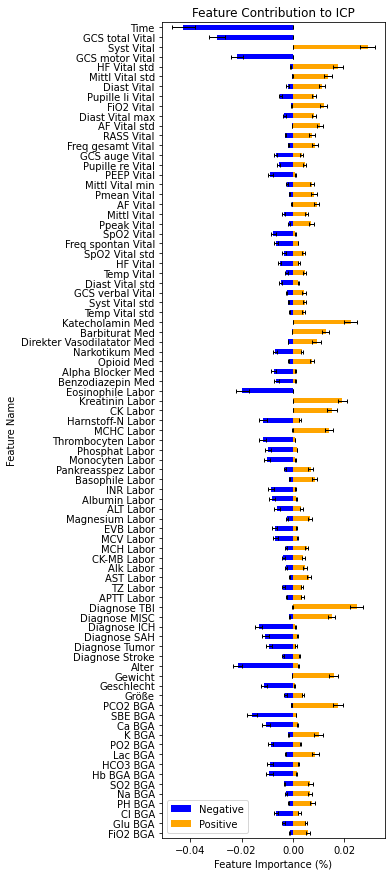

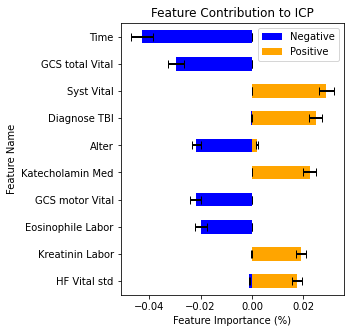

In [250]:
def create_feat_imp_rank_plots(all_saliencies, name=""):
    # pos parts
    mean_pos_sal = [(only_pos(norm(s))).mean(axis=0) for s in all_saliencies]
    pos_data = np.mean(mean_pos_sal, axis=0)
    pos_data_std = np.std(mean_pos_sal, axis=0)

    # neg parts
    mean_neg_sal = [(only_neg(norm(s))).mean(axis=0) for s in all_saliencies]
    neg_data = np.mean(mean_neg_sal, axis=0)
    neg_data_std = np.std(mean_neg_sal, axis=0)

    feature_names = list(dm.feature_names)
    clean_feat_names = [f.replace("_", " ") if f != "rel_time" else "Time" for f in feature_names]
    clean_feat_names = [f[0].upper() + f[1:] for f in clean_feat_names]
    name_mapping = {f: c for f,c in zip(feature_names, clean_feat_names)}

    groups = [f.split("_")[-1] for f in feature_names]

    feat_sal_df = pd.DataFrame({"Neg": neg_data, "Pos": pos_data, 
                                "sal": np.abs(neg_data) + pos_data, 
                                "Feature Names": list(feature_names),
                                "Neg Std": neg_data_std, "Pos Std": pos_data_std,
                               },
                               index=clean_feat_names).sort_values("sal", ascending=True)
    sal_sum = feat_sal_df["sal"].sum()
    feat_sal_df["Pos"] /= sal_sum
    feat_sal_df["Neg"] /= sal_sum

    feat_sal_df["group"] = feat_sal_df["Feature Names"].apply(lambda string: string.split("_")[0] if "Diagnose" in string else ((string.split("_")[-1] if len(string.split("_")) > 1 else "Demographics")))
    feat_sal_df.loc[feat_sal_df["group"] == "std", "group"] = "Vital"
    feat_sal_df.loc[feat_sal_df["group"] == "min", "group"] = "Vital"
    feat_sal_df.loc[feat_sal_df["group"] == "max", "group"] = "Vital"


    # sort by group
    #feat_sal_df = feat_sal_df.sort_values("group")

    top_feat_names = feat_sal_df["Feature Names"]
    top_feats = top_feat_names.tolist()
    top_feats.reverse() # highest first

    # make plot of all feats
    fig, ax = plt.subplots(figsize=(4, 15))
    plot_df = feat_sal_df.copy().sort_values(["group", "sal"], ascending=True)

    #sns.barplot(data=plot_df, x="Pos", ax=ax, y=plot_df.index, color="orange", error="Pos Std")
    #p = plot_df.plot.barh(ax=ax, color="orange", label="Positive", xerr="Pos Std", x="Pos")
    p = plot_df["Neg"].plot.barh(ax=ax, color="blue", label="Negative")
    ax.errorbar(plot_df["Neg"], range(len(plot_df)), xerr=plot_df["Neg Std"], fmt='none', ecolor='black',
               elinewidth=1, capsize=2)
    p = plot_df["Pos"].plot.barh(ax=ax, color="Orange", label="Positive")
    ax.errorbar(plot_df["Pos"], range(len(plot_df)), xerr=plot_df["Pos Std"], fmt='none', ecolor='black',
               elinewidth=1, capsize=2)
    plt.legend()
    plt.xlabel("Feature Importance (%)")
    plt.ylabel("Feature Name")
    plt.title("Feature Contribution to ICP")
    os.makedirs(os.path.join(export_path, f"plots"), exist_ok=True)
    plt.savefig(os.path.join(export_path, f"plots/{name}_{cfg['db_name']}_feature_importance_pos_neg_all.pdf"),
                bbox_inches="tight")
    plt.show()


    # make plot of top 10 feats
    top_feat_num = 10
    fig, ax = plt.subplots(figsize=(4, 5))
    plot_df = feat_sal_df.copy().sort_values("sal", ascending=True).iloc[-top_feat_num:]

    #sns.barplot(data=plot_df, x="Pos", ax=ax, y=plot_df.index, color="orange", error="Pos Std")
    #p = plot_df.plot.barh(ax=ax, color="orange", label="Positive", xerr="Pos Std", x="Pos")
    p = plot_df["Neg"].plot.barh(ax=ax, color="blue", label="Negative")
    ax.errorbar(plot_df["Neg"], range(len(plot_df)), xerr=plot_df["Neg Std"], fmt='none', ecolor='black',
               elinewidth=2, capsize=4)
    p = plot_df["Pos"].plot.barh(ax=ax, color="Orange", label="Positive")
    ax.errorbar(plot_df["Pos"], range(len(plot_df)), xerr=plot_df["Pos Std"], fmt='none', ecolor='black',
               elinewidth=2, capsize=4)
    plt.legend()
    plt.xlabel("Feature Importance (%)")
    plt.ylabel("Feature Name")
    plt.title("Feature Contribution to ICP")
    os.makedirs(os.path.join(export_path, f"plots"), exist_ok=True)
    plt.savefig(os.path.join(export_path, f"plots/{name}_{cfg['db_name']}_feature_importance_pos_neg_all_top{top_feat_num}.pdf"),
                bbox_inches="tight")
    plt.show()
    return top_feats

top_feats = create_feat_imp_rank_plots(all_saliencies)

In [251]:
# go through all diags
len(all_raw_inputs)

1242

Tumor


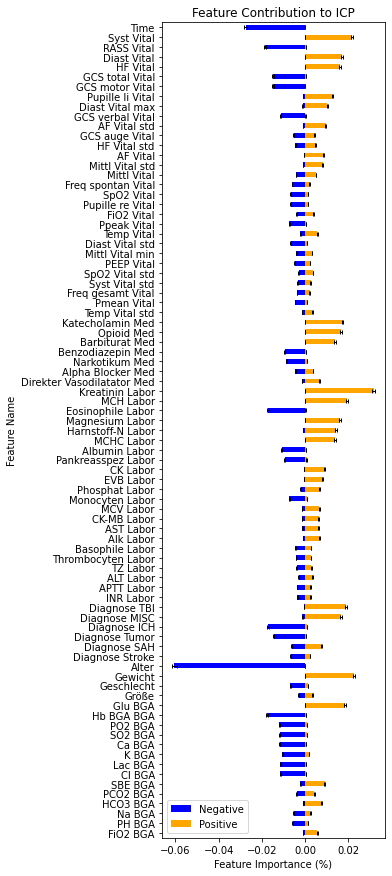

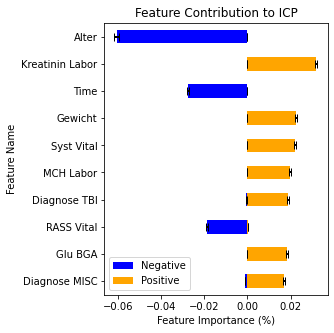

TBI


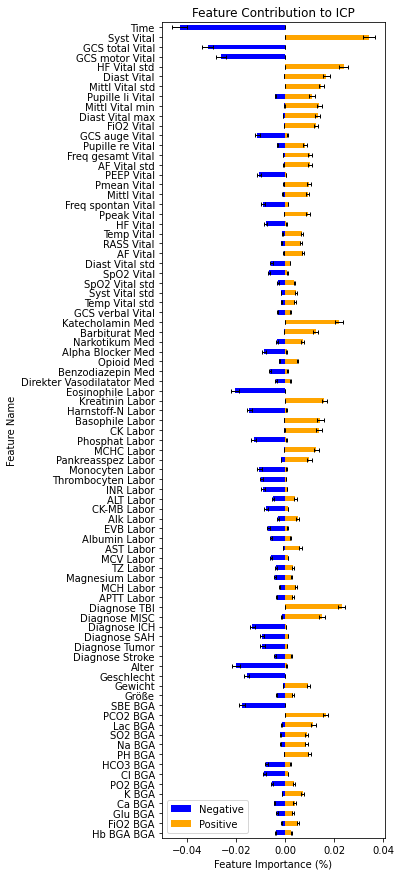

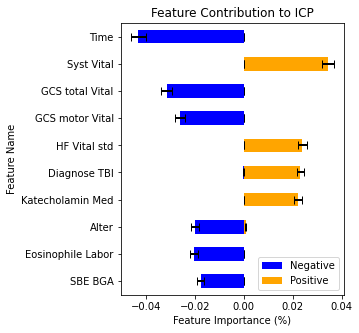

SAH


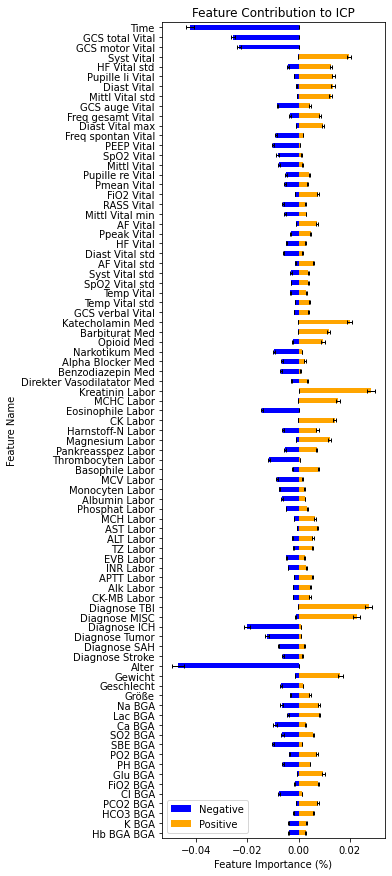

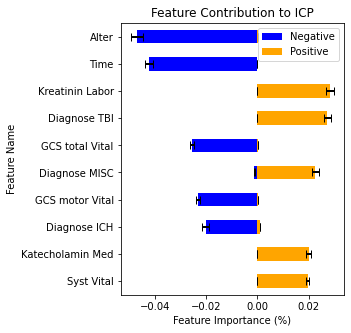

MISC


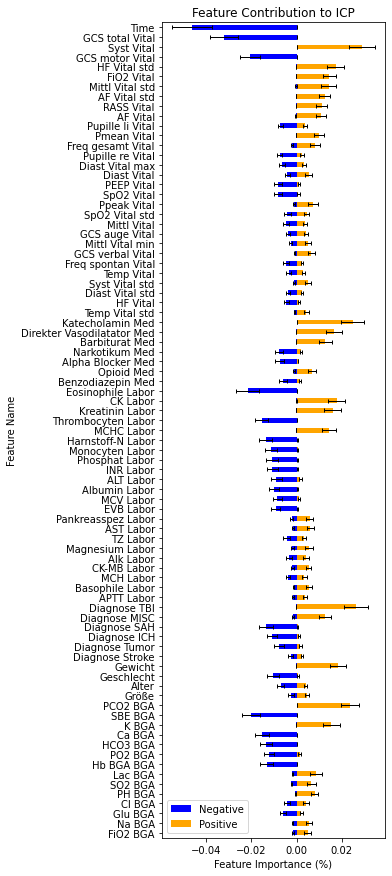

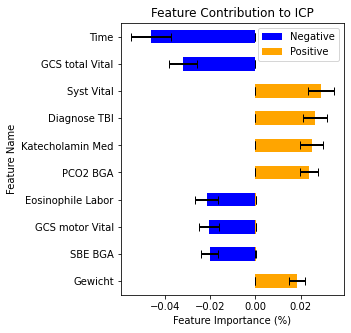

ICH


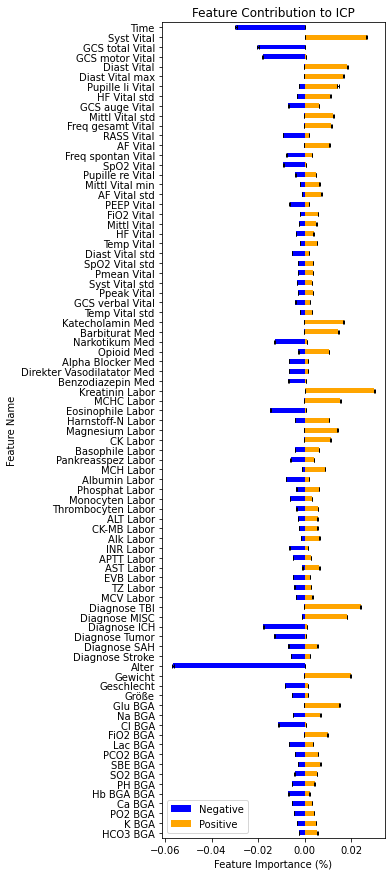

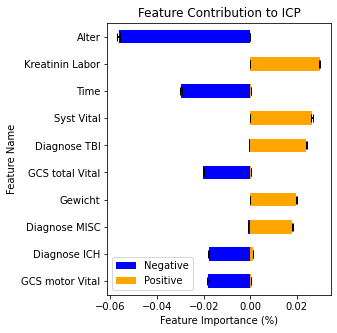

Stroke


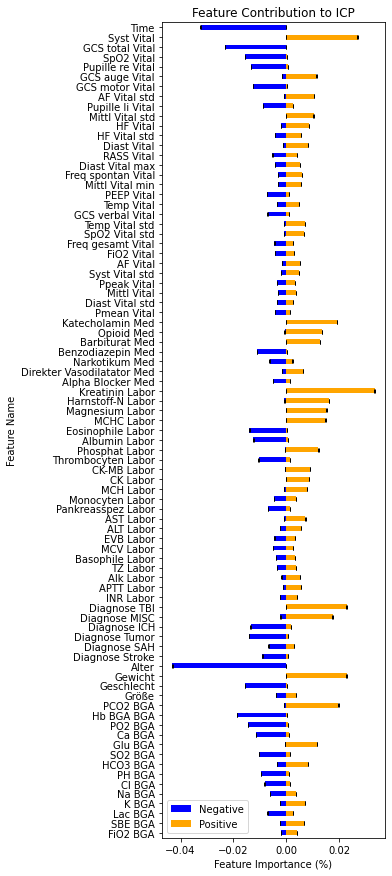

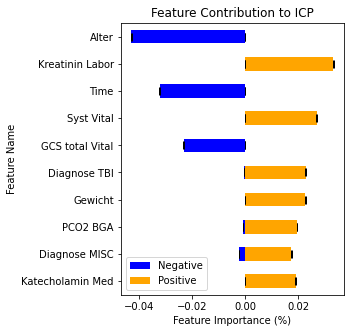

In [252]:
diagnoses = input_df.Diagnose.unique()

for diag in diagnoses:
    print(diag)
    sals_diag = [sal for i, sal in enumerate(all_saliencies) if all_raw_inputs[i]["Diagnose_" + diag].iloc[0] == 1]
    create_feat_imp_rank_plots(sals_diag, name=diag)

In [253]:
len(all_saliencies)

1242

In [254]:
def minmax(a):
    return (a - a.min()) / (a.max() - a.min())

In [255]:
## do ABPC
from icp_pred.eval_utils import make_eval_preds

do_abpc = True

if do_abpc:
    num_feats_to_drop = 20

    models_to_use = [models[best_model_idx]]

    # calc baseline for model
    pert_targets, pert_preds, pert_raw_inputs = make_eval_preds(models_to_use,
                                                                    used_dms, cfg["block_size"],
                                                                    restrict_to_block_size=cfg["block_size"] <= 16,
                                                                    clip_targets=1, 
                                                                    normalize_targets=cfg["norm_targets"],
                                                                    split = "val",
                                                                    return_saliency=False,
                                                                    deleted_feature_idcs=[],
                                                                    fill_type=cfg["fill_type"],
                                                                    verbose=False,
                                                                   )
    baseline_metrics, _, _ = calc_metrics(pert_targets, pert_preds)
    
    morf_metrics = []
    lerf_metrics = []
    for i in tqdm(range(num_feats_to_drop)):
        # compute MoRF part
        idcs = [list(dm.feature_names).index(name) for name in top_feats[:i+1]]
        pert_targets, pert_preds, pert_raw_inputs = make_eval_preds(models_to_use,
                                                                    used_dms, cfg["block_size"],
                                                                    restrict_to_block_size=cfg["block_size"] <= 16,
                                                                    clip_targets=1, 
                                                                    normalize_targets=cfg["norm_targets"],
                                                                    split = "val",
                                                                    return_saliency=False,
                                                                    deleted_feature_idcs=idcs,
                                                                    fill_type=cfg["fill_type"],
                                                                    verbose=False,
                                                                    deletion_prob=0.,
                                                                   )
        pert_metrics, flat_pert_targets, flat_pert_preds = calc_metrics(pert_targets, pert_preds)
        morf_metrics.append(pert_metrics)

        # compute LeRF part
        idcs = [list(dm.feature_names).index(name) for name in top_feats[(-1 * i) - 1:]]
        pert_targets, pert_preds, pert_raw_inputs = make_eval_preds(models_to_use,
                                                                    used_dms, cfg["block_size"],
                                                                    restrict_to_block_size=cfg["block_size"] <= 16,
                                                                    clip_targets=1, 
                                                                    normalize_targets=cfg["norm_targets"],
                                                                    split = "val",
                                                                    return_saliency=False,
                                                                    deleted_feature_idcs=idcs,
                                                                    fill_type=cfg["fill_type"],
                                                                    verbose=False,
                                                                    deletion_prob=0.,
                                                                   )
        pert_metrics, flat_pert_targets, flat_pert_preds = calc_metrics(pert_targets, pert_preds)
        lerf_metrics.append(pert_metrics)

100%|███████████████████████████████████████████| 20/20 [00:58<00:00,  2.94s/it]


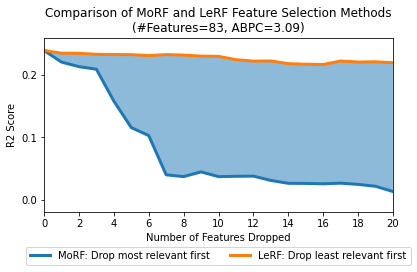

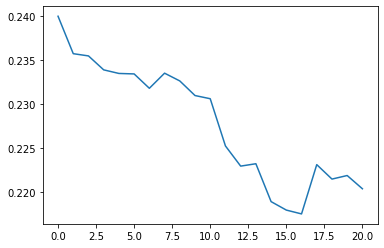

In [256]:
if do_abpc:
    import matplotlib.pyplot as plt
    import numpy as np

    # Plot Area between MoRF and LeRF
    # Data for the plot
    morf_r2 = np.array([baseline_metrics["r2"]] + [m["r2"] for m in morf_metrics])
    lerf_r2 = np.array([baseline_metrics["r2"]] + [m["r2"] for m in lerf_metrics])
    abpc = np.sum(lerf_r2 - morf_r2).round(2)
    num_feats_to_drop = len(morf_r2) - 1

    # Plot MoRF and LeRF R2 scores
    plt.plot(morf_r2, label="MoRF: Drop most relevant first", linewidth=3)
    plt.plot(lerf_r2, label="LeRF: Drop least relevant first", linewidth=3)

    # Shade the area between the two lines
    plt.fill_between(range(num_feats_to_drop + 1), morf_r2, lerf_r2, alpha=0.5)

    # Add plot elements
    plt.legend(bbox_to_anchor=(0.5, -0.2), ncols=2, loc="upper center", borderaxespad=0)
    plt.title(f"Comparison of MoRF and LeRF Feature Selection Methods\n(#Features={len(dm.feature_names)}, ABPC={abpc})")
    plt.xlabel("Number of Features Dropped")
    plt.ylabel("R2 Score")
    # Set tick locations and labels
    ticks = plt.xticks(range(0, num_feats_to_drop+1, 2))
    ticks = plt.xlim((0, num_feats_to_drop))

    ticks = plt.yticks(np.arange(0, 0.44, 0.1))
    # Set y-axis limits
    if cfg["db_name"] == "UKE":
        plt.ylim(-0.0, 0.41)
    else:
        plt.ylim(-0.02, 0.26)
    # Adjust plot layout
    plt.tight_layout()
    # Save the plot
    if do_export:
        folder = os.path.join(export_path, "plots")
        os.makedirs(folder, exist_ok=True)
        plt.savefig(os.path.join(folder, "ABPC.pdf"), bbox_inches="tight")
        pd.DataFrame({"morf": morf_r2, "lerf": lerf_r2}).to_csv(os.path.join(folder, "abpc.csv"))
    # Display the plot
    plt.show()
    
    plt.plot(lerf_r2)
    plt.show()

In [257]:
# plot robustness to missingness when random features are dropped


from icp_pred.eval_utils import make_eval_preds

models_to_use = models
num_rounds = 5
metric = "r2"

num_feats = len(dm.feature_names)
del_probs = np.linspace(1, 0, 10)
del_perfs_all = []
for round_idx in range(num_rounds):
    del_perfs = []
    for del_prob in tqdm(del_probs):
        idcs = list(range(num_feats))
        #idcs = [list(dm.feature_names).index(name) for name in top_feats[:i+1]]
        pert_targets, pert_preds, pert_raw_inputs = make_eval_preds(models_to_use,
                                                                    used_dms, cfg["block_size"],
                                                                    restrict_to_block_size=cfg["block_size"] <= 16,
                                                                    clip_targets=1, 
                                                                    normalize_targets=cfg["norm_targets"],
                                                                    split = "val",
                                                                    return_saliency=False,
                                                                    deleted_feature_idcs=idcs,
                                                                    fill_type=cfg["fill_type"],
                                                                    verbose=False,
                                                                    deletion_prob=del_prob,
                                                                   )
        pert_metrics, flat_pert_targets, flat_pert_preds = calc_metrics(pert_targets, pert_preds)
        del_perfs.append(pert_metrics[metric])
        del_perfs_all.append(del_perfs)
        
        
mean_perf = np.mean(del_perfs_all, axis=0)
std_perf = np.std(del_perfs_all, axis=0)

plt.plot(del_probs, mean_perf)
plt.fill_between(del_probs, mean_perf - std_perf, mean_perf + std_perf, alpha=0.4)
plt.title("Robustness of Model to Missingness")
plt.ylabel("R2 Score")
plt.xlabel("Fraction of Data Kept")


# Save the plot
if do_export:
    folder = os.path.join(export_path, "plots")
    os.makedirs(folder, exist_ok=True)
    plt.savefig(os.path.join(folder, "missing_robustness.pdf"), bbox_inches="tight")

100%|███████████████████████████████████████████| 10/10 [01:38<00:00,  9.85s/it]


In [261]:
plt_ind_trajs = False

if plt_ind_trajs:
    idx = 1
    start = 0
    limit = 50
    save = False

    # TODO: make scale for both plots equal
    top_n = top_feats[:20]

    os.makedirs(os.path.join(export_path, "single_trajectories"), exist_ok=True)
    for idx in tqdm(range(len(all_inputs) // len(models))):
        #if np.nanmax(all_targets[idx][start:limit]) < 30:
        #    continue
        #else:
        #    print(idx)

        fig, ax = plt.subplots()
        plt.title("Real ICP and Input Values")
        # heatmap
        data = all_inputs[idx].numpy()
        #data = all_raw_inputs[idx].to_numpy()
        ind_sal_df = pd.DataFrame(data,
                                  columns=feature_names)
        ind_sal_df = ind_sal_df[top_n].iloc[start:limit]
        ind_sal_df.columns = [name_mapping[c] for c in ind_sal_df.columns]


        cmap_white_red = sns.color_palette("Reds", as_cmap=True)
        cmap = sns.color_palette("vlag", as_cmap=True)
        "icefire"

        sns.heatmap(ind_sal_df.T, cbar_kws = dict(use_gridspec=True, location="right", pad=0.15), cmap=cmap_white_red)
        plt.xlabel("Time (h)")
        plt.ylabel("Feature Name")


        preds_pat_traj = all_preds[idx][start:limit]
        plot_data = all_targets[idx][start:limit]
        min_target_ICP, max_target_ICP = np.nanmin(plot_data), np.nanmax(plot_data)
        min_pred_ICP, max_pred_ICP = min(preds_pat_traj), max(preds_pat_traj)
        min_ICP, max_ICP = min(min_target_ICP, min_pred_ICP) -0.5, max(max_target_ICP, max_pred_ICP) + 0.5
        # ICP line
        ax2 = ax.twinx()
        ax2.set_ylabel("ICP")

        ax2.scatter(range(len(plot_data)), plot_data, linewidth=5)
        ax2.set_ylim(min_ICP, max_ICP)
        plt.xticks(range(0, len(plot_data), 5), range(0, len(plot_data), 5))

        plt.tight_layout()
        # save
        if save:
            final_save_path = os.path.join(export_path, "single_trajectories", f"target_pat{idx}_{start}_{limit}.pdf")
            os.makedirs(folder, exist_ok=True)
            plt.savefig(final_save_path, dpi=400, bbox_inches="tight")



        ## Predicted ICP and saliencies
        fig, ax = plt.subplots()
        plt.title("Predicted ICP and Saliencies")
        data = all_saliencies[idx]
        data = norm(data) * 1000
        ind_sal_df = pd.DataFrame(data,
                                  columns=feature_names)
        ind_sal_df = ind_sal_df[top_n].iloc[start:limit]
        ind_sal_df.columns = [name_mapping[c] for c in ind_sal_df.columns]

        sns.heatmap(ind_sal_df.T, cbar_kws = dict(use_gridspec=True, location="right", pad=0.2), cmap=cmap, center=0)
        plt.xlabel("Time (h)")
        plt.ylabel("Feature Name")


        # ICP line
        ax2 = ax.twinx()
        ax2.set_ylabel("ICP")
        ax2.set_ylim(min_ICP, max_ICP)
        ax2.plot(preds_pat_traj, linewidth=3)

        plt.xticks(range(0, len(plot_data), 5), range(0, len(plot_data), 5))
        plt.tight_layout()

        # save
        if save:
            final_save_path = os.path.join(export_path, "single_trajectories", f"pred_pat{idx}_{start}_{limit}.pdf")
            plt.tight_layout()
            plt.savefig(final_save_path, dpi=400, bbox_inches="tight")

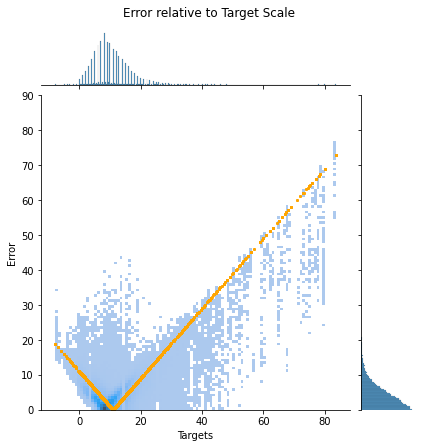

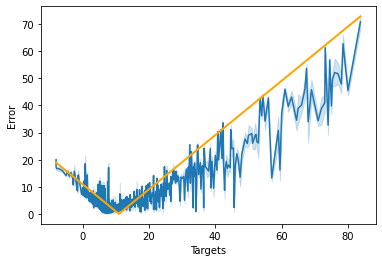

In [265]:
# comparison to mean baseline

if dm.regression:
    df_nona = input_df.dropna(subset=["targets"]).reset_index()
    #mean_pred_error = (df_nona["targets"] - dm.preprocessor.mean_train_target).dropna() ** 2
    #error = (df_nona["targets"] - df_nona["preds"]) ** 2
    #df_nona["error"] = error
    #plot_df = pd.DataFrame({"Targets": flat_targets, "Preds": flat_preds})
    #plot_df["Error"] = (plot_df["Targets"] - plot_df["Preds"]).abs().tolist()
    df_nona["Error"] = df_nona["mae"].to_numpy()
    df_nona["Targets"] = df_nona["targets"].to_numpy()
    ax = sns.jointplot(x="Targets", y="Error", data=df_nona, kind="hist", bins=100) # data=by_pat
    p = ax.ax_joint.scatter(df_nona["Targets"], (np.ones(len(df_nona["Targets"])) * dm.preprocessor.mean_train_target - df_nona["Targets"]).abs(), s=2, color="orange")
    
    #plt.xlim(-20, 100)
    plt.ylim(0, 90)
    ax.fig.suptitle("Error relative to Target Scale", y=1.03)
    
    if do_export:
        #plt.savefig("plots/ind_study/errors_vs_mean.png", dpi=400, bbox_inches="tight")
        plt.savefig(os.path.join(export_path, "errors_vs_mean.pdf"), dpi=400, bbox_inches="tight")
        
    plt.figure()
    ax = sns.lineplot(data = df_nona, x="Targets", y="Error")
    sorted_by_targets = df_nona.copy().sort_values("Targets")
    p = ax.plot(sorted_by_targets["Targets"], (np.ones(len(sorted_by_targets["Targets"])) * dm.preprocessor.mean_train_target - sorted_by_targets["Targets"]).abs(), linewidth=2, color="orange")
    if do_export:
        plt.savefig(os.path.join(export_path, "errors_vs_mean_lineplot.pdf"), dpi=400, bbox_inches="tight")

In [266]:
#if dm.regression:
#    ylim = (df_nona["preds"].min() - 5, df_nona["preds"].max() + 5)
#    ax = sns.jointplot(data=df_nona, x="targets", y="preds", kind="reg", ylim=ylim) # data=bypat
#    min_val = df_nona["targets"].min()
#    max_val = df_nona["targets"].max()
#    ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2, color="black", label="Ideal model")

-8.0 83.75


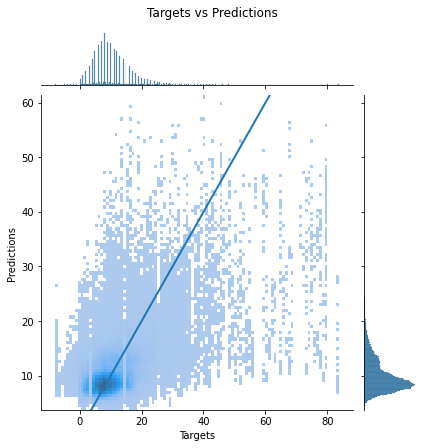

In [267]:
if dm.regression:
    ylim = (flat_preds.min() - 0, flat_preds.max() + 0)
    min_val = flat_targets.min()
    max_val = flat_targets.max()
    plot_df = pd.DataFrame({"Targets": flat_targets, "Preds": flat_preds})
    ax = sns.jointplot(x="Targets", y="Preds", data=plot_df, kind="hist", bins=100, ylim=ylim)
    print(min_val, max_val)
    # draw line of perfect correlation
    ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2)#, color="black")
    ax.ax_joint.set_ylabel("Predictions")
    ax.fig.suptitle("Targets vs Predictions", y=1.03)
    plt.savefig("plots/ind_study/targets_vs_preds.png", dpi=400, bbox_inches="tight")

In [268]:
if dm.regression:
    #pats = df.groupby("ids").filter(lambda x: x['preds'].max() > 16)
    #pats = pred_df.groupby("ids").filter(lambda x: x['targets'].mean() > 20)
    pats = pred_df.groupby("ids").filter(lambda x: x['targets'].max() > 20)
    #pats = df.groupby("ids").filter(lambda x: np.sqrt(x['error'].mean()) > 30)
else:
    pats = pred_df.groupby("ids").filter(lambda x: x['preds'].mean() > 0.2)
pats = pats.groupby("ids").filter(lambda x: len(x["targets"].dropna()) > 2)

ids = pats["ids"].unique()
print(ids)
print(len(ids), "patients")
#pats

[  1.   2.   3.   4.   5.   6.   7.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  21.  22.  23.  26.  28.  29.  30.  31.  33.  35.  38.  39.
  40.  43.  44.  45.  49.  51.  52.  53.  57.  58.  59.  63.  64.  66.
  67.  68.  71.  72.  73.  74.  76.  77.  79.  82.  83.  86.  88.  89.
  90.  91.  92.  93.  98. 101. 103. 104. 105. 106. 110. 111. 113. 114.
 115. 118. 121. 122. 124. 126. 128. 129. 130. 131. 132. 133. 134. 136.
 137. 139. 141. 142. 143. 144. 146. 147. 148. 149. 150. 151. 152. 154.
 155. 156. 157. 158. 161. 162. 163. 165. 171. 173. 174. 175. 176. 177.
 178. 182. 183. 184. 185. 186. 187. 192. 194. 195. 196. 199. 200. 202.
 204. 205.]
128 patients


mean average target:  10.927189918235488
mean pat targets:  19.300907082603775
R2 of model:  0.2505157086818094
RMSE of model: 6.38
RMSE of mean: 11.16
MAPE of model:  0.26
MAPE of mean:  0.49


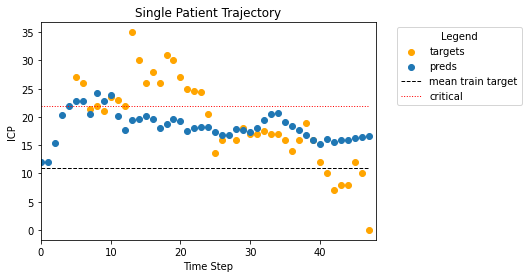

In [269]:
from icp_pred.eval_utils import mape
import sklearn

pat_id = 0
model_id = 0
limit = 50

pat = pred_df[pred_df["ids"] == ids[pat_id]]
pat = pat[pat["model_id"] == model_id]
if not dm.regression:
    pat["preds"] = torch.sigmoid(torch.tensor(pat["preds"].to_numpy())).numpy()

if limit is not None:
    pat = pat[:limit]

plt.scatter(pat["step"], pat["targets"], label="targets", color="orange")
plt.scatter(pat["step"], pat["preds"], label="preds")
mean = dm.preprocessor.mean_train_target
print("mean average target: ", mean)
print("mean pat targets: ", pat["targets"].mean())
plt.plot([0, max(pat["step"])], [mean, mean], linewidth=1, color="black", label="mean train target", linestyle="--")
if dm.regression:
    plt.plot([0, max(pat["step"])], [22, 22], linewidth=1, color="red", label="critical", linestyle=":")

#plt.legend(location="out")
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, max(pat["step"]) + 1)
plt.ylabel("ICP")
plt.xlabel("Time Step")
plt.title("Single Patient Trajectory")
pat_nona = pat[~pat["targets"].isna()]
print("R2 of model: ", sklearn.metrics.r2_score(pat_nona["targets"], pat_nona["preds"]))
print("RMSE of model:", round(np.sqrt(sklearn.metrics.mean_squared_error(pat_nona["targets"], pat_nona["preds"])), 2))
print("RMSE of mean:", round(np.sqrt(sklearn.metrics.mean_squared_error(pat_nona["targets"], [mean] * len(pat_nona))), 2))
print("MAPE of model: ", round(mape(pat_nona["targets"], pat_nona["preds"]), 2))
print("MAPE of mean: ", round(mape(pat_nona["targets"], [mean] * len(pat_nona)), 2))

In [270]:
# TODO: show heatmap of salience for single patients
# TODO: fix legend names

In [271]:
#for i in range(len(dm.train_ds.targets)):
#    d = dm.train_ds.targets[i]
#    d = d[~torch.isnan(d)].max()
#    print(d)

## Saliency

In [272]:
feature_names = dm.feature_names

In [273]:
import shap


def classical_saliency(models, dms, model_type, use_shap=False, verbose=True):
    # plot feature importance
    all_importances = []
    all_inputs = []
    
    for model, data_module in zip(models, dms):
        if use_shap:
            explainer = shap.TreeExplainer(model)
            inputs = data_module.val_dataloader().dataset.flat_inputs
            importances = explainer.shap_values(inputs)
            all_inputs.append(inputs)
        else:
            if hasattr(model, "feature_importances_"):
                importances = model.feature_importances_
            elif hasattr(model, "coef_"):
                importances = model.coef_
        all_importances.append(importances)
    if not use_shap and verbose and hasattr(model, "importance_type"):
        print("Importance type: ", model.importance_type)
    print("importances shapes:")
    for imp in all_importances:
        print(imp.shape)
    importances = np.concatenate(all_importances)
    inputs = np.concatenate(all_inputs)
    mean_importances = importances.mean(axis=0)
    # save
    path = f"outputs/{model_type}"
    os.makedirs("outputs", exist_ok=True)
    
    block_size = cfg["flat_block_size"]

    
    if use_shap:
        #shap.summary_plot(mean_importances, X_test, plot_type="bar")
        #shap.summary_plot(mean_importances, X_test)
        #shap.summary_plot(mean_importances)
        #input_df = pd.DataFrame(inputs, columns=feature_names)
        #shap_df = pd.DataFrame(mean_importances, columns=feature_names)
        
        #vals= np.abs(shap_values).mean(0)
        #feature_importance = pd.DataFrame(list(zip(feature_names, vals)),columns=['col_name','feature_importance_vals'])
        #feature_importance = feature_importance.sort_values(by=['feature_importance_vals'], ascending=False)
        #feature_importance.head()
                
        if verbose:
            if block_size < 2:
                block_feat_names = feature_names
            else:
                block_feat_names = []
                for i in range(block_size):
                    block_feat_names.extend([f + f"_{i}" for f in feature_names])
            shap.summary_plot(importances, features=inputs, 
                              feature_names=block_feat_names)
            plt.savefig(path + "_shap_importances.jpg", bbox_inches='tight')
        
        
        # average over block_size/time_steps
       
        if block_size > 1:
            print(mean_importances.shape)
            mean_importances = mean_importances.reshape(-1, len(feature_names), block_size).mean(axis=-1)
            print(mean_importances.shape)


        imp_per_feat = np.abs(mean_importances).mean(axis=0)
        feat_df = pd.Series(imp_per_feat, index=feature_names)
    else:
        # make plot
        if block_size > 1:
            print(mean_importances.shape)
            mean_importances = np.abs(mean_importances.reshape(len(feature_names), block_size)).mean(axis=-1)
            print(mean_importances.shape)
        
        
        feat_df = pd.Series(mean_importances, index=feature_names)
        if verbose:
            p = feat_df.sort_values().plot.barh(figsize=(4, 25))
            p.figure.savefig(path + "_importances.jpg", bbox_inches='tight')
        
    feat_df = feat_df.sort_values(ascending=True)
    return feat_df


def reduce_feat_df(feat_df, threshold=0.2):
    # remove everything above 90% explained importance
    print(len(feat_df))
    feat_df = feat_df / feat_df.sum()
    reduced_df = feat_df[feat_df.cumsum() > threshold]
    print(len(reduced_df))
    print(reduced_df.sum())
    print(reduced_df)
    reduced_feats = list(reduced_df.index)
    return reduced_feats


In [274]:
if cfg["model_type"] in ["xgb", "log"]:
    sal_df = classical_saliency(models, dms, cfg["model_type"], 
                                use_shap=True, verbose=True)
    
    sal_df_normed = sal_df / sal_df.sum()
    sal_df_normed.sort_values().iloc[-10:]
    
    reduced_feats = reduce_feat_df(sal_df, threshold=0.15)
    reduced_feats

In [275]:
models[0].cpu()
torch.cuda.empty_cache()

In [276]:
dms

In [277]:
import icp_pred.saliency
from icp_pred.saliency import get_sal_list
import importlib
importlib.reload(icp_pred.saliency)

torch.cuda.empty_cache()


if not cfg["model_type"] in ["xgb", "log"]:

    sal_list = []
    for model, dm in zip(models, dms):
        model.cuda()
        max_backprop_len = 128 
        model_saliency = get_sal_list(model, 0, perc=1.0, agg=True, 
                                      ds=dm.val_dataloader().dataset, 
                                      ig=False, max_len=max_backprop_len)
        sal_list.append(model_saliency)
        model.cpu()
        torch.cuda.empty_cache()


100%|█████████████████████████████████████████| 207/207 [00:40<00:00,  5.08it/s]


In [278]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [279]:
len(sal_list)

1

In [280]:
# TODO: average over multiple models!
#for sal in sal_list:

mean_overall = [s.mean(0) for s in sal_list[0]]
feat_saliency = np.sum(mean_overall, axis=0)
feature_names = dm.feature_names
feat_sal_df = pd.DataFrame({"sal": feat_saliency}, index = feature_names).sort_values("sal")

<Figure size 432x288 with 0 Axes>

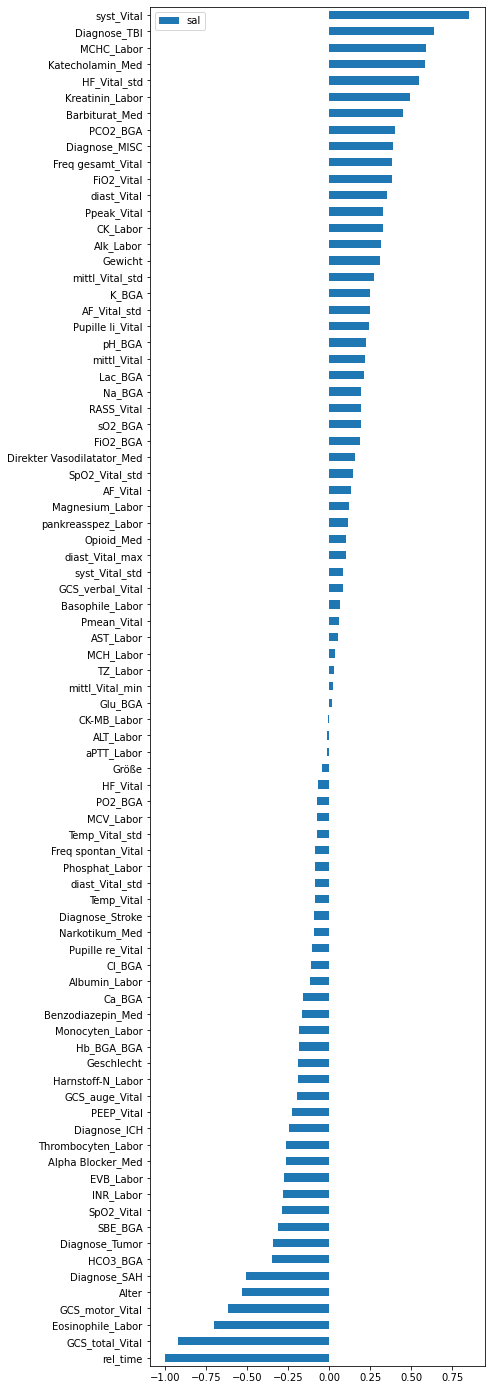

In [282]:
plt.figure()
p = feat_sal_df.plot.barh(figsize = (6, 25))
p.figure.savefig("plots/ind_study/raw_importances.jpg", bbox_inches='tight')
plt.show()

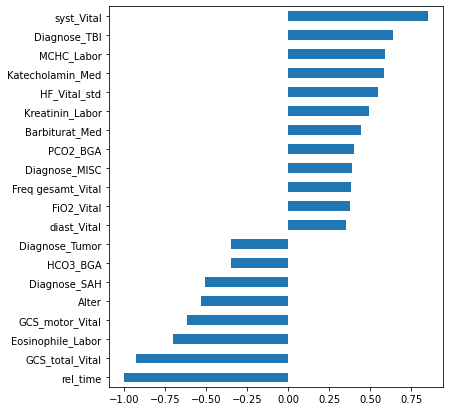

In [283]:
# only top 20
plt.figure()
plot_df = feat_sal_df.copy()
plot_df["abs"] = feat_sal_df.abs()
plot_df = plot_df.sort_values("abs", ascending=False).iloc[:20]
p = plot_df["sal"].sort_values().plot.barh(figsize = (6, 7))
p.figure.savefig("plots/ind_study/top_20_importances.jpg", bbox_inches='tight')
plt.show()

In [284]:
len(feature_names)

83

In [285]:
sal = sal_list[0]

all_steps = []
for i, s in enumerate(sal):
    pat_df = pd.DataFrame(s, columns=feature_names)
    pat_df["pat_id"] = i
    pat_df["step"] = np.arange(s.shape[0])
    all_steps.append(pat_df)
sal_df = pd.concat(all_steps, axis=0)

In [286]:
pred_df

,targets,preds,ids,step,error,model_id,mean_train_target,std_train_target
0,NaN,10.756209,0.0,0,NaN,0,10.92719,8.33932
1,NaN,10.525858,0.0,1,NaN,0,10.92719,8.33932
2,NaN,10.028013,0.0,2,NaN,0,10.92719,8.33932
3,NaN,9.496173,0.0,3,NaN,0,10.92719,8.33932
4,NaN,9.183482,0.0,4,NaN,0,10.92719,8.33932
...,...,...,...,...,...,...,...,...
30522,8.0,6.133750,206.0,97,0.050082,5,10.92719,8.33932
30523,8.0,6.046149,206.0,98,0.054894,5,10.92719,8.33932
30524,9.0,5.974546,206.0,99,0.131619,5,10.92719,8.33932
30525,8.0,5.900807,206.0,100,0.063364,5,10.92719,8.33932


In [287]:
dl_type

'val'

In [288]:
N = 4

# kick out pats with less than N measurements
sal_df_min_N = sal_df[sal_df.groupby("pat_id").step.transform(len) >= N]
# calculate N averaged steps per patient
averaged_df = []
for pat_id in sal_df_min_N.pat_id.unique():
    pat_df = sal_df_min_N[sal_df_min_N.pat_id == pat_id]
    parts = np.array_split(pat_df, N)
    for part in parts:
        averaged_df.append(part.mean())
averaged_df = pd.DataFrame(averaged_df)

In [289]:
pred_df.columns

Index(['targets', 'preds', 'ids', 'step', 'error', 'model_id',
       'mean_train_target', 'std_train_target'],
      dtype='object')

In [290]:
# do the same as above for pred_df

# kick out pats with less than N measurements
pred_df_min_N = pred_df[pred_df.groupby("ids").step.transform(len) >= N]
# calculate N averaged steps per patient
averaged_pred_df = []
for pat_id in pred_df_min_N.ids.unique():
    pat_df = pred_df_min_N[pred_df_min_N.ids == pat_id]
    parts = np.array_split(pred_df_min_N, N)
    for part in parts:
        mean_part = part.mean()
        mean_part = mean_part / mean_part.sum()
        averaged_pred_df.append(mean_part)
averaged_pred_df = pd.DataFrame(averaged_pred_df)

In [291]:
averaged_pred_df

,targets,preds,ids,step,error,model_id,mean_train_target,std_train_target
0,0.039418,0.038838,0.304224,0.543950,0.002520,0.001208,0.039611,0.030230
1,0.035608,0.034604,0.384097,0.474486,0.002390,0.005479,0.035922,0.027414
2,0.038998,0.038281,0.300987,0.538163,0.002519,0.011955,0.039189,0.029908
3,0.035247,0.034588,0.380207,0.469681,0.002398,0.015185,0.035557,0.027136
4,0.039418,0.038838,0.304224,0.543950,0.002520,0.001208,0.039611,0.030230
...,...,...,...,...,...,...,...,...
823,0.035247,0.034588,0.380207,0.469681,0.002398,0.015185,0.035557,0.027136
824,0.039418,0.038838,0.304224,0.543950,0.002520,0.001208,0.039611,0.030230
825,0.035608,0.034604,0.384097,0.474486,0.002390,0.005479,0.035922,0.027414
826,0.038998,0.038281,0.300987,0.538163,0.002519,0.011955,0.039189,0.029908


In [292]:
#averaged_df

In [293]:
averaged_df

,rel_time,AF_Vital,AF_Vital_std,ALT_Labor,AST_Labor,Albumin_Labor,Alk_Labor,Basophile_Labor,CK-MB_Labor,CK_Labor,...,Geschlecht,Alpha Blocker_Med,Barbiturat_Med,Benzodiazepin_Med,Direkter Vasodilatator_Med,Katecholamin_Med,Narkotikum_Med,Opioid_Med,pat_id,step
0,-0.002911,0.001128,-0.000208,0.000700,0.000823,-0.001574,0.002307,0.000781,0.001943,0.000117,...,0.000058,0.000040,0.003606,-0.001344,-0.001136,0.000889,-0.002401,0.002013,0.0,2.0
1,-0.002752,0.000860,0.000224,0.000663,0.001345,-0.000911,0.002726,0.001187,0.001828,-0.000720,...,0.000486,-0.000426,0.002722,-0.002255,-0.000970,-0.000240,-0.003298,0.000632,0.0,7.0
2,-0.005533,0.001262,0.000265,0.000339,-0.000041,-0.000721,0.003492,0.002139,0.001702,-0.000829,...,0.000054,-0.000703,0.003509,-0.003034,-0.000085,0.001484,-0.004523,0.000980,0.0,11.5
3,-0.002226,0.001153,0.000537,0.000039,0.000043,-0.000695,0.001626,0.000668,0.000844,-0.000181,...,-0.000388,-0.000020,0.001760,-0.001202,0.000515,0.001125,-0.001531,0.001279,0.0,15.5
4,-0.003954,0.000337,0.000593,0.000633,0.000387,0.000264,0.000540,0.000579,0.000132,0.001525,...,-0.001154,-0.001863,0.002046,-0.000686,-0.001744,0.001905,-0.001155,-0.000092,1.0,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,-0.001003,0.000366,-0.000007,0.000270,-0.000056,-0.001131,0.000030,-0.000142,-0.000256,0.000768,...,-0.000065,0.000347,0.000751,-0.000150,-0.000184,0.000907,0.000107,0.000647,205.0,132.0
804,-0.000797,-0.000138,0.000070,0.000155,0.000105,-0.000246,0.000493,0.000087,0.000320,0.000121,...,0.000162,-0.000278,0.000659,-0.000228,-0.000341,0.000247,-0.000675,0.000232,206.0,12.5
805,-0.000553,0.000029,0.000072,0.000095,0.000015,-0.000365,0.000302,0.000038,0.000168,-0.000021,...,-0.000043,-0.000056,0.000474,-0.000190,-0.000346,0.000173,-0.000362,0.000230,206.0,38.5
806,-0.000802,0.000017,-0.000100,-0.000080,0.000173,-0.000527,0.000474,0.000008,0.000271,0.000096,...,-0.000232,0.000023,0.000671,-0.000133,-0.000345,0.000145,-0.000200,0.000309,206.0,64.0


In [ ]:
# train umap on averaged steps
from umap import UMAP
umapper = UMAP(n_neighbors=5, min_dist=0.1)
sal_data = averaged_df.drop(columns=["pat_id", "step"])
#umap_embedding = umapper.fit_transform(sal_data)

In [ ]:
averaged_df

In [ ]:
# plot umap
import umap.plot
#umap.plot.points(umapper, labels=averaged_df.pat_id)
umap.plot.points(umapper, 
                 #values=averaged_df.Katecholamin_Med,
                 values=averaged_pred_df["error"],
                 theme="fire")

In [ ]:
plot_df = pd.DataFrame(umap_embedding, columns=["x", "y"])
plot_df["cluster"] = cluster_labels
plot_df["error"] = averaged_pred_df["error"]

In [ ]:
sns.lmplot(x="x", y="y", data=plot_df, fit_reg=False,
           #hue='error',
           col="error",
           legend=True)

In [ ]:
plt.figure(figsize=(10,10))
sns.lmplot(x="x", y="y", data=plot_df, fit_reg=False,
           hue='error',
           #col="cluster",
           #row="error",
           legend=True,
          )

In [ ]:
# cluster averaged using K-means
from sklearn.cluster import KMeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
#clustering_data = sal_data
clustering_data = umap.UMAP(n_neighbors=10, min_dist=0.1).fit_transform(sal_data)
kmeans.fit(clustering_data)
cluster_labels = kmeans.labels_

In [ ]:
# label histogram
plt.figure()
plt.hist(cluster_labels, bins=10)

In [ ]:
plot_df

In [ ]:
sns.lmplot( x="x", y="y", data=plot_df, fit_reg=False, hue='cluster', legend=True)

In [ ]:
# show boxplots next to each other of each cluster
# sort columns by overall absolute mean importance value

# make subplots
fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(10, 10), sharey=True)
for i in range(n_clusters):
    ax = axes[i]
    data = sal_data[cluster_labels == i]
    sns.stripplot(data=data, orient="h", palette="Set2", color=".25", alpha=0.3, ax=ax)
    sns.boxplot(data=data, orient="h", palette="Set2", showfliers=False, ax=ax)

In [ ]:
# print boxplot for each feature per clusters
for i in range(np.max(cluster_labels) + 1):
    cluster_data = sal_data[cluster_labels == i]
    # sort feature columns by absolute value
    mean_abs = cluster_data.abs().mean(axis=0)
    sorted_data = sorted(cluster_data.transpose().values, key=lambda x: np.abs(x).mean())
    sorted_columns = sorted(cluster_data.columns, key=lambda x: np.abs(cluster_data[x]).mean())
    # only show top N
    N = 6
    sorted_data = sorted_data[-N:] 
    sorted_columns = sorted_columns[-N:]
    
    # now sort by mean value without abs
    mean_data = cluster_data.mean(axis=0)
    sorted_data = sorted(sorted_data, key=lambda x: x.mean())
    sorted_columns = sorted(sorted_columns, key=lambda x: mean_data[x])
    
    # show boxplot where the feature name is at the y-axis
    #plt.figure(figsize=(5, 5))
    #plt.boxplot(sorted_data, labels=sorted_columns, whis=1.5, vert=False)
    #plt.show()
    # show variant where each single point is shown
    #plt.figure(figsize=(5, 5))
    #plt.scatter(cluster_data.index, cluster_data[sorted_columns[0]], c=cluster_labels)
    sorted_df = pd.DataFrame(sorted_data, index=sorted_columns)
    sns.stripplot(data=sorted_df.transpose(), orient="h", palette="Set2", color=".25", alpha=0.3)
    sns.boxplot(data=sorted_df.transpose(), orient="h", palette="Set2", showfliers=False)
    plt.xlim(-0.04, 0.04)
    #sns.stripplot(data=sorted_df.transpose(), orient="h", palette="Set2", color=".25")
    plt.show()
    

In [ ]:
sns.stripplot(data=sorted_df.transpose(), orient="h", palette="Set2", color=".25", alpha=0.3)
sns.boxplot(data=sorted_df.transpose(), orient="h", palette="Set2", showfliers=False)
plt.show()